In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [513]:
train = pd.read_csv('ps1_dataA_15TC.csv', header=None)
time_indices = list(train.iloc[4:, 0])
train = train.iloc[4:, 1:]
train.reset_index(drop=True, inplace=True)

In [514]:
train_data = {'time': [],
        'r':[],
        'z':[],
        'temperature': []
        }

for i in range(5):
    for j in range(3):
        for k in range(len(time_indices)):
            train_data['r'].append(j*0.25)
            train_data['z'].append(i*0.25)
            train_data['temperature'].append(train.iloc[k,(i*3+j)%15])
            train_data['time'].append(time_indices[k])

train_df = pd.DataFrame(train_data)

In [515]:
def get_index_train(r,z,t):
    index = 251*(r//0.25) + 251*3*(z//0.25) + t*10
    return int(index)

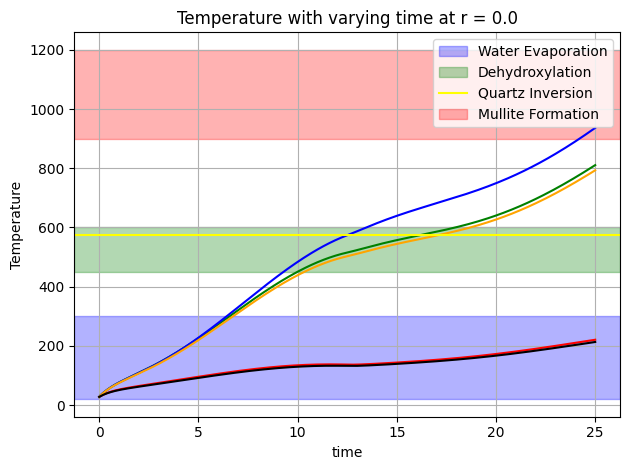

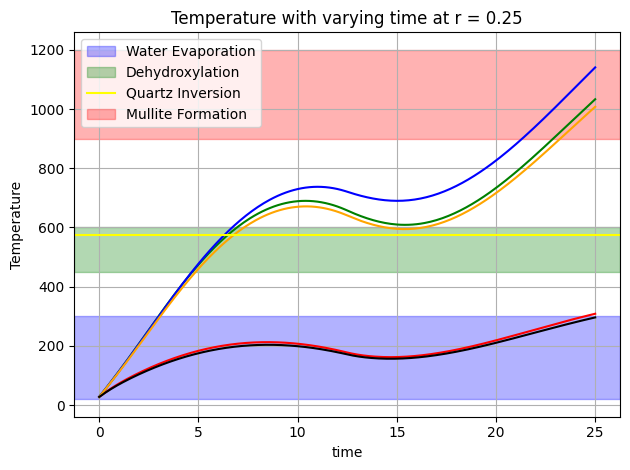

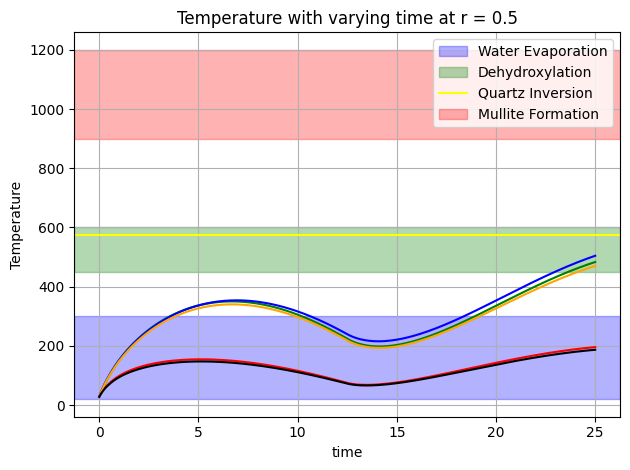

In [516]:
colors = ["red","green","blue","orange","black"]
for i in range(3):
    for j in range(5):
        ind = get_index_train(i*0.25,j*0.25,0)
        plt.plot(train_df.iloc[ind:ind+251,0],train_df.iloc[ind:ind+251,3], color = colors[j])
    plt.title(f"Temperature with varying time at r = {i*0.25}")
    plt.xlabel('time')
    plt.ylabel("Temperature")
    plt.grid(True)
    plt.axhspan(20, 300, color='blue', alpha=0.3, label='Water Evaporation')
    plt.axhspan(450, 600, color='green', alpha=0.3, label='Dehydroxylation')
    plt.axhline(573,color='yellow',label='Quartz Inversion')
    plt.axhspan(900, 1200, color='red', alpha=0.3, label='Mullite Formation')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [517]:
a_train = pd.DataFrame(train_data)
a_train

time    r    z  temperature
0      0.0  0.0  0.0    27.998536
1      0.1  0.0  0.0    31.794445
2      0.2  0.0  0.0    35.462488
3      0.3  0.0  0.0    38.513040
4      0.4  0.0  0.0    41.189601
...    ...  ...  ...          ...
3760  24.6  0.5  1.0   184.628387
3761  24.7  0.5  1.0   185.280613
3762  24.8  0.5  1.0   185.912706
3763  24.9  0.5  1.0   186.524496
3764  25.0  0.5  1.0   187.115819

[3765 rows x 4 columns]

In [518]:
a_train = train_df

In [519]:
df_test = pd.read_csv('ps1_dataA_120TC.csv', header=None)
df_test = df_test.iloc[4:, 1:]
df_test.reset_index(drop=True, inplace=True)
df_test.index = time_indices

In [520]:
test_data = {'time': [],
             'r': [],
             'z': [],
             'temperature': []
             }

for i in range(15):
    for j in range(8):
        for k in range(len(time_indices)):
            test_data['r'].append(j/14)
            test_data['z'].append(i/14)
            test_data['temperature'].append(df_test.iloc[k,(i*8+j)%120])
            test_data['time'].append(time_indices[k])

df_test_new = pd.DataFrame(test_data)

In [521]:
df_test_new

time    r    z  temperature
0       0.0  0.0  0.0    27.998536
1       0.1  0.0  0.0    31.794445
2       0.2  0.0  0.0    35.462488
3       0.3  0.0  0.0    38.513040
4       0.4  0.0  0.0    41.189601
...     ...  ...  ...          ...
30115  24.6  0.5  1.0   184.628387
30116  24.7  0.5  1.0   185.280613
30117  24.8  0.5  1.0   185.912706
30118  24.9  0.5  1.0   186.524496
30119  25.0  0.5  1.0   187.115819

[30120 rows x 4 columns]

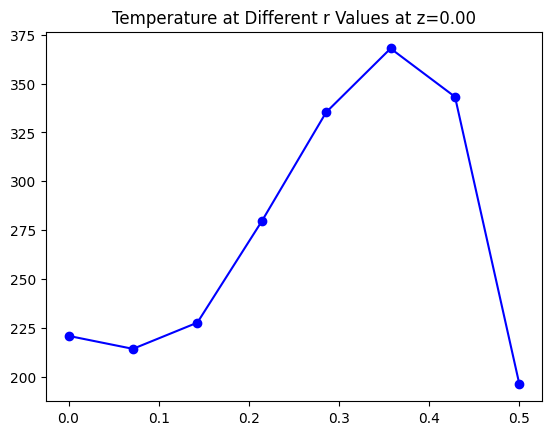

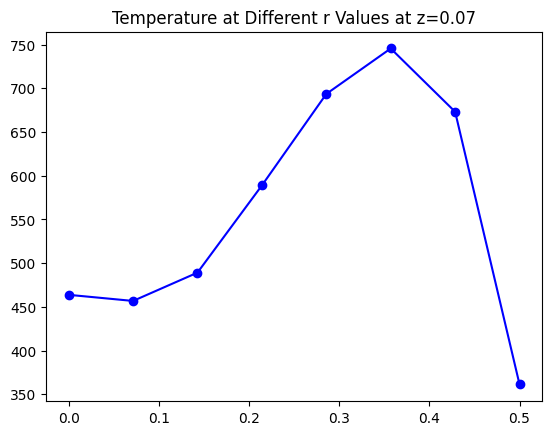

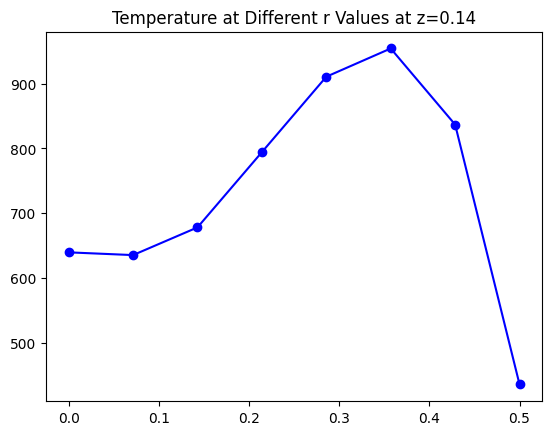

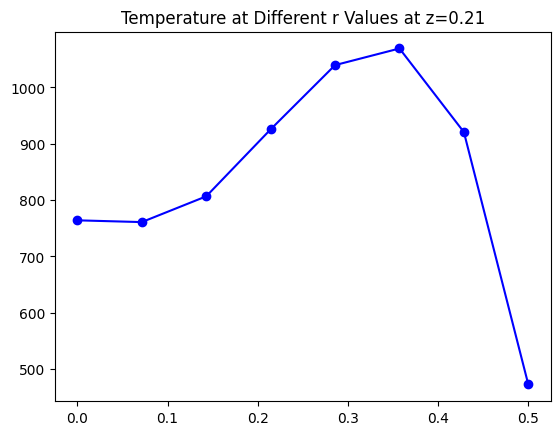

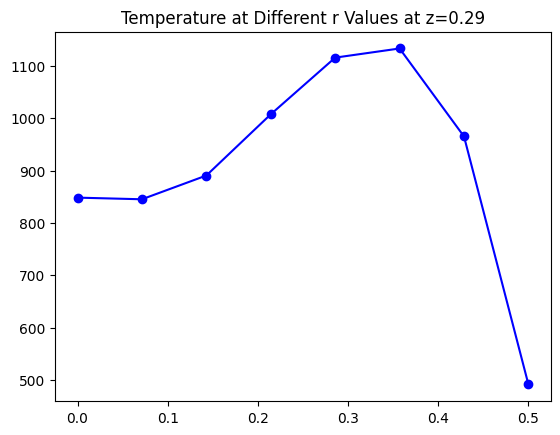

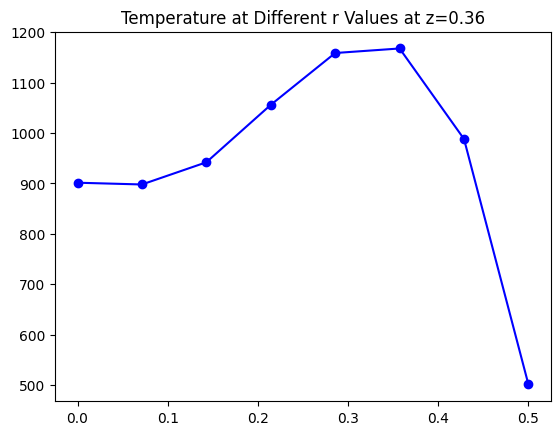

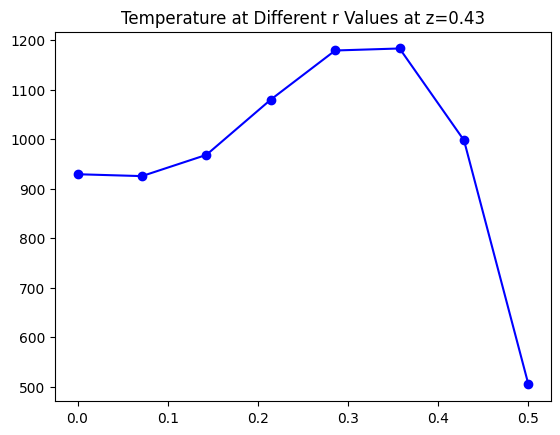

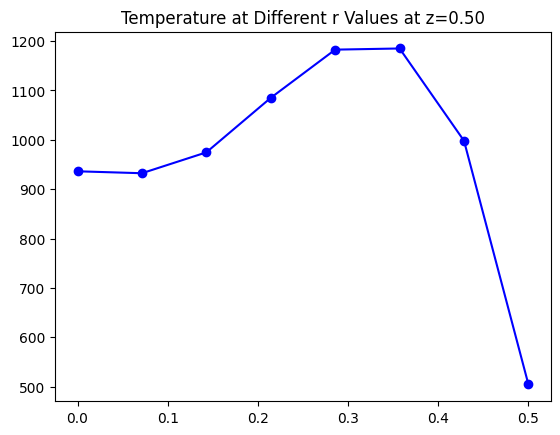

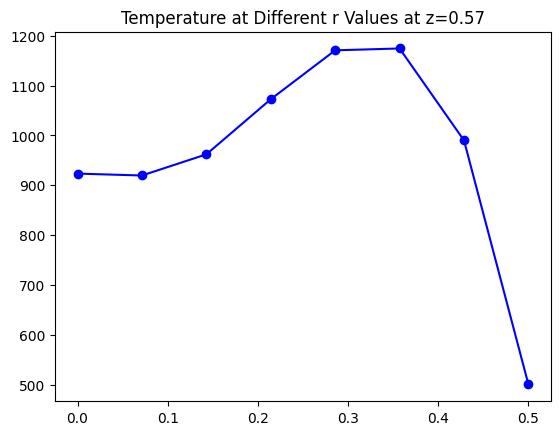

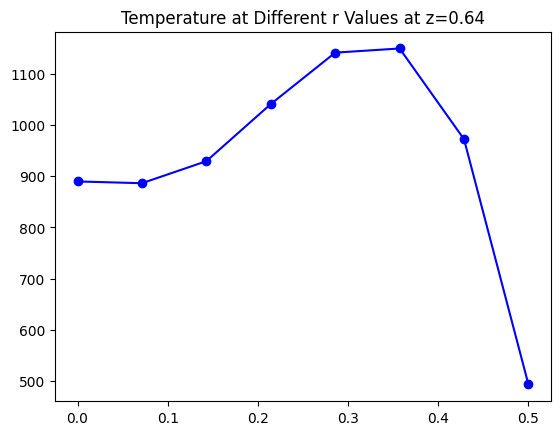

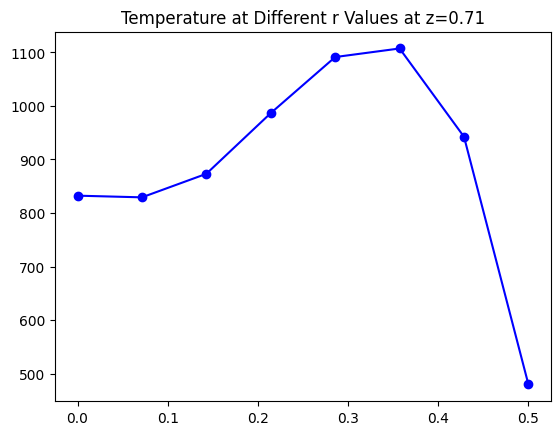

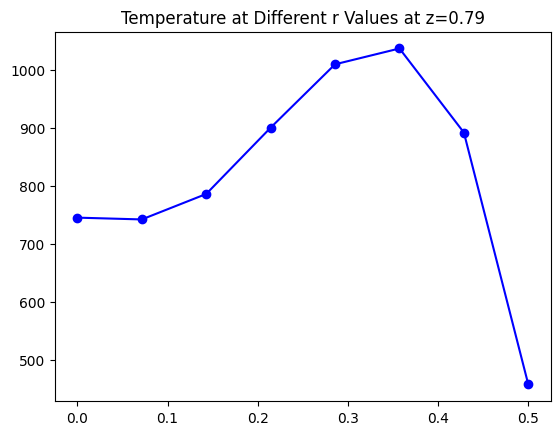

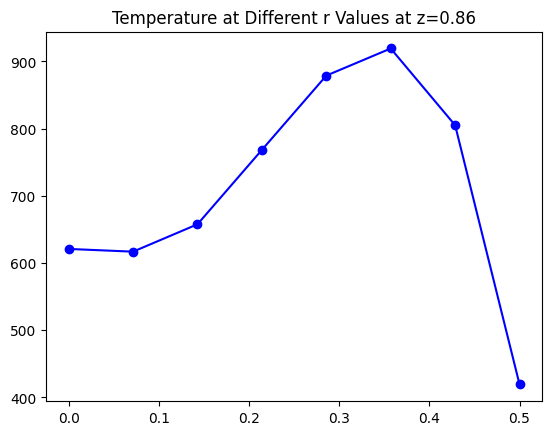

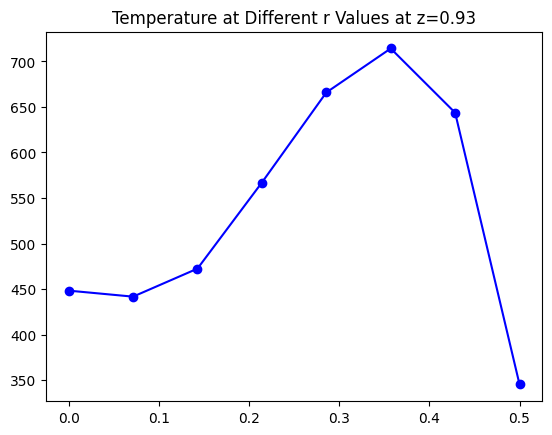

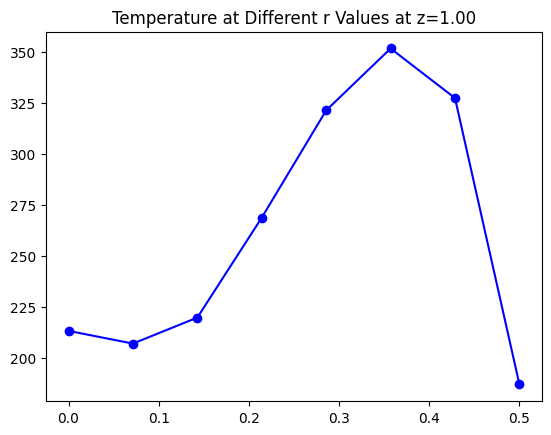

In [522]:
# Variation of temperature with r
for j in range(15):
    vals = []
    for i in range(8):
        vals.append(df_test_new.iloc[i*251+j*251*8+250,[1,3]])

    dd = pd.DataFrame(vals, columns=['r', 'temperature'])

    plt.plot(dd['r'], dd['temperature'], marker='o', linestyle='-', color='blue')
    plt.title('Temperature at Different r Values at z={:.2f}'.format(df_test_new.iloc[j*251*8,2]))
    plt.show()

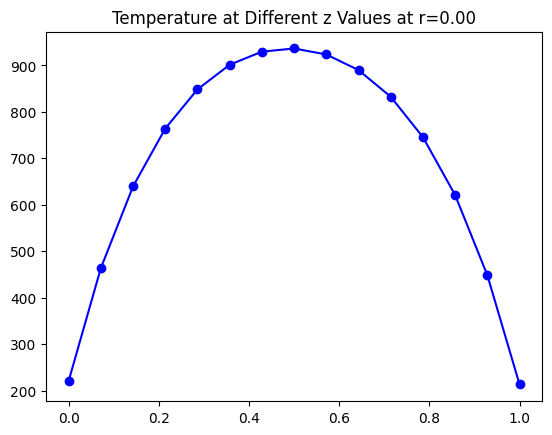

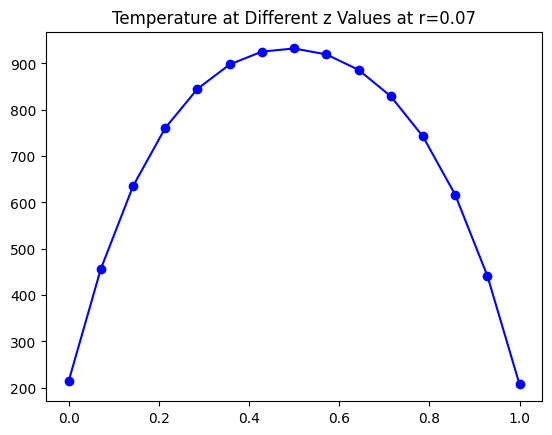

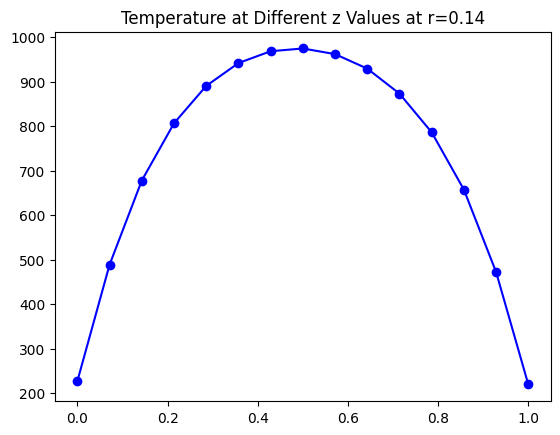

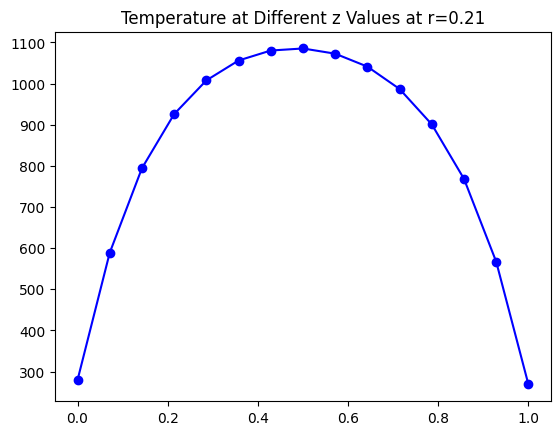

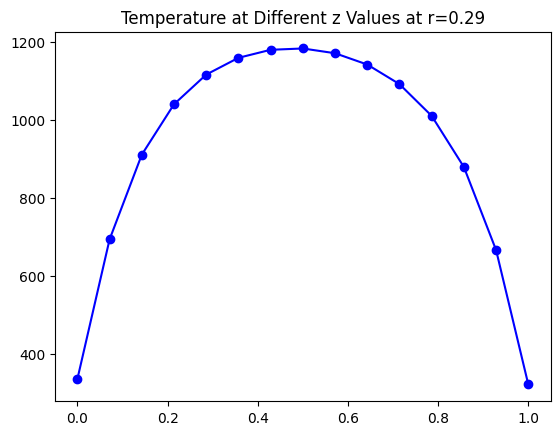

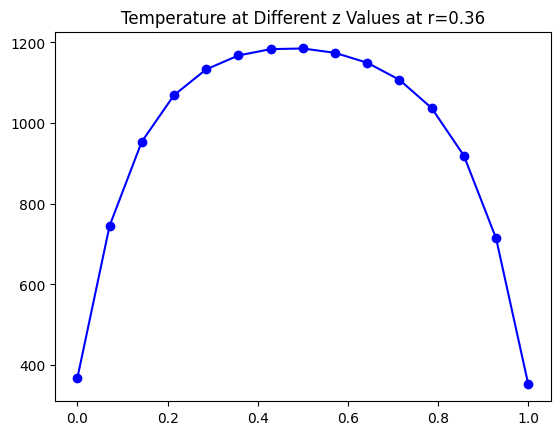

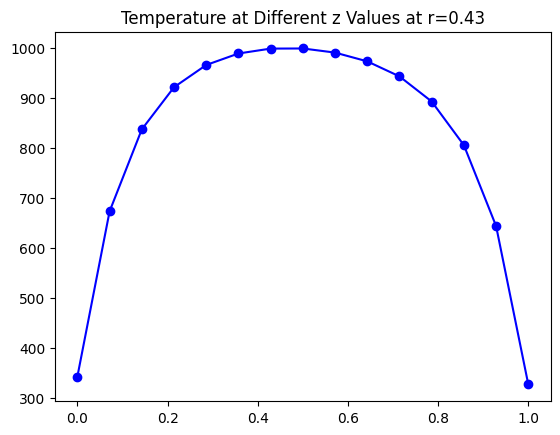

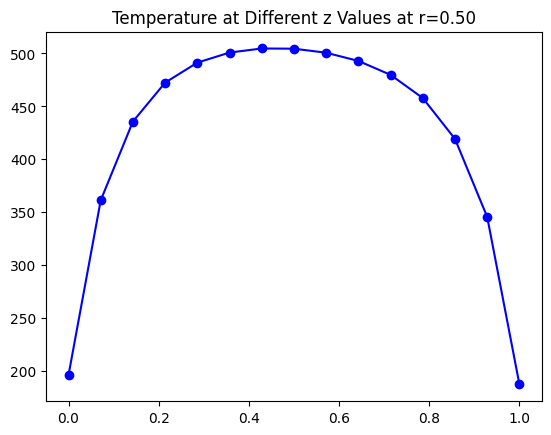

In [523]:
# Variation of temperature with z
for j in range(8):
    vals = []
    for i in range(15):
        vals.append(df_test_new.iloc[j*251+i*251*8+250,[2,3]])

    dd = pd.DataFrame(vals, columns=['z', 'temperature'])

    plt.plot(dd['z'], dd['temperature'], marker='o', linestyle='-', color='blue')
    plt.title('Temperature at Different z Values at r={:.2f}'.format(df_test_new.iloc[j*251,1]))
    plt.show()

In [524]:
# Device configuration - VERIFY GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Verify GPU details if available
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.8 GB


In [525]:
# Configuration Class
class ImprovedPhysCfg:
    # Material properties
    k = 1.0         # W/m-K (typical ceramic thermal conductivity)
    rho = 1700.0     # kg/m^3 (ceramic density)
    cp = 1000.0       # J/kg-K (ceramic specific heat)

    # Geometry Data A
    R = 0.5          # m (radius)
    H = 1.0          # m (height)

    # Convection ]
    h = 20.0        # W/m^2-K (natural convection in air)
    T_inf = 1500.0     # °C ambient

    # Time conversion
    t_scale = 3600.0  # Convert hours to seconds

    # Training hyperparams
    lr_initial = 5e-4
    lr_min = 1e-6

    # Training hyperparams
    max_epochs_phase1 = 4000
    max_epochs_phase2 = 6000
    patience = 1000

    # Adaptive batch sizes
    batch_colloc = 8192
    batch_bc = 1024

    # Adaptive weight scheduling
    w_ramp_epochs = 500

    # Improved loss weights with adaptive scaling
    w_data_phase1 = 1.0
    w_pde_phase1 = 0.0
    w_bc_phase1 = 0.0

    w_data_phase2 = 100.0
    w_pde_phase2 = 0.01
    w_bc_phase2 = 0.1

    # Adaptive weight scheduling
    w_adaptive = True
    w_ramp_epochs = 20

    # Enhanced reaction model
    use_reactions = True
    reactions = [
        # Water evaporation - endothermic
        dict(name="evaporation", A=1e8, E=44e3, H=44e3, T_range=(100, 300)),
        # Dehydroxylation - endothermic
        dict(name="dehydroxylation", A=1e12, E=222e3, H=480e3, T_range=(450, 600)),
        # Mullite formation - exothermic
        dict(name="mullite formation", A=1e10, E=400e3, H=-200e3, T_range=(900, 1200)),
    ]
    R_gas = 8.314  # J/mol-K

cfg = ImprovedPhysCfg()

In [526]:
# Model Class
class ImprovedPINN(nn.Module):
    def __init__(self, layers=(3, 512, 128, 64, 32, 1)):
        super().__init__()

        # Input normalization layer
        self.input_norm = nn.BatchNorm1d(3)

        # Main network with residual connections
        self.layers = nn.ModuleList()
        self.residual_connections = []

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            self.layers.append(layer)

            # Mark residual connections
            if i > 0 and i < len(layers) - 2 and layers[i] == layers[i + 1]:
                self.residual_connections.append(i)

        self.activations = [
            nn.GELU(),
            nn.GELU(),
            nn.GELU(),
            nn.GELU(),
            nn.GELU(),
            None
        ]

        # Output scaling to help with gradient flow
        self.output_scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        # Input normalization
        if x.shape[0] > 1:  # Only apply if batch size > 1
            x = self.input_norm(x)

        # Forward through network with residual connections
        h = x
        for i, layer in enumerate(self.layers[:-1]):
            h_new = layer(h)

            # Apply activation
            if self.activations[i] is not None:
                h_new = self.activations[i](h_new)

            # Add residual connection if applicable
            if i in self.residual_connections and h.shape == h_new.shape:
                h = h + h_new
            else:
                h = h_new

        # Output layer
        output = self.layers[-1](h)
        return output * self.output_scale


In [527]:
# Physics Functions
def Q_gen_enhanced(T):
    if not cfg.use_reactions:
        return torch.zeros_like(T)

    T_K = T + 273.15
    Q_total = torch.zeros_like(T)

    for reaction in cfg.reactions:
        A = reaction["A"]
        E = reaction["E"]
        H = reaction["H"]
        T_range = reaction.get("T_range", (0, 2000))

        # Temperature-dependent activation (smooth step function)
        T_min, T_max = T_range
        activation = torch.sigmoid((T - T_min) * 0.1) * torch.sigmoid(-(T - T_max) * 0.1)

        exp_term = torch.clamp(-E / (cfg.R_gas * T_K), min=-50, max=10)
        rate = A * torch.exp(exp_term)

        # Add reaction contribution
        Q_total = Q_total + H * rate * activation

    return Q_total

def physics_loss_enhanced(model, X_in):
    Xc = X_in.detach().clone().requires_grad_(True)
    r_phys = Xc[:, 0:1]
    z_phys = Xc[:, 1:2]
    t_phys = Xc[:, 2:3]

    T = model(Xc)

    grads = torch.autograd.grad(T, Xc, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_r = grads[:, 0:1]
    T_z = grads[:, 1:2]
    T_t = grads[:, 2:3]

    T_rr = torch.autograd.grad(T_r, Xc, grad_outputs=torch.ones_like(T_r), create_graph=True)[0][:, 0:1]
    T_zz = torch.autograd.grad(T_z, Xc, grad_outputs=torch.ones_like(T_z), create_graph=True)[0][:, 1:2]

    inv_r = 1.0 / (r_phys + 1e-8)
    laplacian = T_rr + inv_r * T_r + T_zz
    T_t_seconds = T_t / cfg.t_scale
    Q_gen_val = Q_gen_enhanced(T)
    pde_residual = cfg.rho * cfg.cp * T_t_seconds - cfg.k * laplacian - Q_gen_val

    loss = torch.mean(pde_residual ** 2)
    return loss

In [528]:
def get_collocation_batch_fn(batch_size):
    """Returns (batch_size, 3) tensor of (r, z, t) points INSIDE the domain"""
    R = cfg.R
    H = cfg.H
    t_max = 25.0  # Adjust based on your data time range

    # Area-weighted sampling for cylindrical coordinates
    r = torch.sqrt(torch.rand(batch_size, 1, device=device)) * R
    z = torch.rand(batch_size, 1, device=device) * H
    t = torch.rand(batch_size, 1, device=device) * t_max

    X = torch.cat([r, z, t], dim=1)
    return X

def get_bc_batch_fn(batch_size_per_side):
    """Returns (X_bc, y_bc) for boundary conditions"""
    R = cfg.R
    H = cfg.H
    t_max = 25.0

    bc_X = []
    bc_targets = []

    # r = 0: axis symmetry (∂T/∂r = 0)
    r = torch.zeros(batch_size_per_side, 1, device=device)
    z = torch.rand(batch_size_per_side, 1, device=device) * H
    t = torch.rand(batch_size_per_side, 1, device=device) * t_max
    bc_X.append(torch.cat([r, z, t], dim=1))
    bc_targets.append(torch.zeros(batch_size_per_side, device=device))

    # r = R: outer boundary (convection)
    r = torch.full((batch_size_per_side, 1), R, device=device)
    z = torch.rand(batch_size_per_side, 1, device=device) * H
    t = torch.rand(batch_size_per_side, 1, device=device) * t_max
    bc_X.append(torch.cat([r, z, t], dim=1))
    bc_targets.append(torch.full((batch_size_per_side,), cfg.T_inf, device=device))

    # z = 0: bottom boundary
    r = torch.sqrt(torch.rand(batch_size_per_side, 1, device=device)) * R
    z = torch.zeros(batch_size_per_side, 1, device=device)
    t = torch.rand(batch_size_per_side, 1, device=device) * t_max
    bc_X.append(torch.cat([r, z, t], dim=1))
    bc_targets.append(torch.full((batch_size_per_side,), cfg.T_inf, device=device))

    # z = H: top boundary
    r = torch.sqrt(torch.rand(batch_size_per_side, 1, device=device)) * R
    z = torch.full((batch_size_per_side, 1), H, device=device)
    t = torch.rand(batch_size_per_side, 1, device=device) * t_max
    bc_X.append(torch.cat([r, z, t], dim=1))
    bc_targets.append(torch.full((batch_size_per_side,), cfg.T_inf, device=device))

    X_bc = torch.cat(bc_X, dim=0)
    y_bc = torch.cat(bc_targets, dim=0)

    return X_bc, y_bc


In [529]:
def boundary_loss_enhanced(model, X_bc):
    X_bc = X_bc.detach().clone().requires_grad_(True)
    r_phys = X_bc[:, 0:1]
    z_phys = X_bc[:, 1:2]

    T = model(X_bc)

    # Calculate gradients
    grads = torch.autograd.grad(T, X_bc, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    T_r = grads[:, 0:1]
    T_z = grads[:, 1:2]

    total_loss = 0.0
    batch_size_per_side = len(X_bc) // 4

    # r = 0: symmetry condition (∂T/∂r = 0)
    axis_loss = torch.mean(T_r[:batch_size_per_side]**2)
    total_loss += axis_loss

    # r = R: convection
    outer_idx = slice(batch_size_per_side, 2*batch_size_per_side)
    T_outer = T[outer_idx]
    T_r_outer = T_r[outer_idx]
    q_conv = cfg.h * (T_outer - cfg.T_inf)
    bc_outer = -cfg.k * T_r_outer + q_conv
    total_loss += torch.mean(bc_outer**2)

    # z = 0: bottom boundary, Insulated
    bottom_idx = slice(2*batch_size_per_side, 3*batch_size_per_side)
    T_bottom = T[bottom_idx]
    T_z_bottom = T_z[bottom_idx]
    q_conv = 0
    bc_bottom = cfg.k * T_z_bottom - q_conv
    total_loss += torch.mean(bc_bottom**2)

    # z = H: top boundary
    top_idx = slice(3*batch_size_per_side, 4*batch_size_per_side)
    T_top = T[top_idx]
    T_z_top = T_z[top_idx]
    q_conv = cfg.h * (T_top - cfg.T_inf)
    bc_top = -cfg.k * T_z_top - q_conv
    total_loss += torch.mean(bc_top**2)

    return total_loss

In [530]:
def prepare_training_tensors(data):
    """
    Prepare training tensors from your data
    Assumes data is a DataFrame or array with columns [r, z, time, temperature]
    """
    if hasattr(data, 'values'):  # DataFrame
        X = torch.tensor(data[['r', 'z', 'time']].values, dtype=torch.float32, device=device)
        y = torch.tensor(data['temperature'].values, dtype=torch.float32, device=device)
    else:  # NumPy array
        X = torch.tensor(data[:, :3], dtype=torch.float32, device=device)  # r, z, t
        y = torch.tensor(data[:, 3], dtype=torch.float32, device=device)   # temperature

    return X, y

In [531]:
# Training Functions
def supervised_loss(model, X_data, y_data):
    """Phase 1: Supervised MSE loss (data only)"""
    pred = model(X_data).squeeze(-1)
    return nn.MSELoss()(pred, y_data)

In [532]:
def train_two_phase(model, X_data, y_data, get_collocation_batch_fn, get_bc_batch_fn, cfg, device='cpu'):
    """Two-phase PINN training (supervised, then physics-informed)"""

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr_initial)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=cfg.patience//10, min_lr=cfg.lr_min)

    print(f"Training on {len(X_data)} data points")

    # Phase 1: Supervised only
    print("\n=== Phase 1: Supervised pre-training ===")
    best_rmse = float('inf')
    patience_counter = 0

    X_ic = X_data[X_data[:, 0] == 0]
    y_ic = y_data[X_data[:, 0] == 0]

    for epoch in range(cfg.max_epochs_phase1):
        model.train()
        optimizer.zero_grad()
        loss = supervised_loss(model, X_data, y_data)
        loss.backward()
        optimizer.step()

        # Evaluate
        with torch.no_grad():
            pred = model(X_data).squeeze(-1)
            mse = nn.MSELoss()(pred, y_data).item()
            rmse = mse ** 0.5

        if rmse < best_rmse - 1e-6:
            best_rmse = rmse
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1

        if epoch % 1000 == 0 or epoch == cfg.max_epochs_phase1-1:
            print(f"Epoch {epoch:4d} | Supervised Loss: {loss.item():.4e} | RMSE: {rmse:.4f}")

        if patience_counter > cfg.patience//4:
            print("Early stopping (Phase 1)")
            break

    model.load_state_dict(best_state)

    # Phase 2: PINN (physics + data + BC)
    print("\n=== Phase 2: Physics-informed training ===")
    best_rmse = float('inf')
    patience_counter = 0

    for epoch in range(cfg.max_epochs_phase2):
        model.train()
        optimizer.zero_grad()

        # Adaptive weight scheduling
        if cfg.w_adaptive:
            ramp_factor = min(1.0, epoch / cfg.w_ramp_epochs)
            w_pde = cfg.w_pde_phase2 * ramp_factor
            w_bc = cfg.w_bc_phase2 * ramp_factor
        else:
            w_pde = cfg.w_pde_phase2
            w_bc = cfg.w_bc_phase2

        # Data loss
        loss_data = supervised_loss(model, X_data, y_data) * cfg.w_data_phase2

        # Collocation loss (physics)
        X_colloc = get_collocation_batch_fn(cfg.batch_colloc)
        loss_pde = physics_loss_enhanced(model, X_colloc) * w_pde

        # BC loss
        X_bc, _ = get_bc_batch_fn(cfg.batch_bc//4)  # Divide by 4 since we have 4 boundaries
        loss_bc = boundary_loss_enhanced(model, X_bc) * w_bc


        # Initial Condition Loss
        loss_ic = supervised_loss(model, X_ic, y_ic)*10000

        total_loss = loss_data + 0.00001*loss_pde + 0.0000000001*loss_bc + loss_ic

        total_loss.backward()
        optimizer.step()

        # Evaluate
        with torch.no_grad():
            pred = model(X_data).squeeze(-1)
            mse = nn.MSELoss()(pred, y_data).item()
            rmse = mse ** 0.5

        if rmse < best_rmse - 1e-6:
            best_rmse = rmse
            patience_counter = 0
            best_state = model.state_dict()
        else:
            patience_counter += 1

        if epoch % 1000 == 0 or epoch == cfg.max_epochs_phase2-1:
            print(f"Epoch {epoch:4d} | Total: {total_loss.item():.4e} | "
                  f"Data: {loss_data.item():.2e}  PDE: {loss_pde.item():.2e} | "
                   f"BC: {loss_bc.item():.2e} | IC: {loss_ic.item():.2e} | RMSE: {rmse:.4f}")

        scheduler.step(total_loss.item())

    model.load_state_dict(best_state)
    print("Training complete.")
    return model

In [533]:
# MAIN EXECUTION
if __name__ == "__main__":
    print("Initializing PINN training...")

    X_data, y_data = prepare_training_tensors(a_train)

    print(f"Data loaded: {len(X_data)} points")
    print(f"Temperature range: {y_data.min().item():.1f} to {y_data.max().item():.1f} °C")

    # Initialize model
    model = ImprovedPINN().to(device)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Train model
    trained_model = train_two_phase(
        model, X_data, y_data,
        get_collocation_batch_fn, get_bc_batch_fn,
        cfg, device=device
    )

    print("Training completed successfully!")

    # Final evaluation
    with torch.no_grad():
        pred = trained_model(X_data).squeeze(-1)
        final_rmse = torch.sqrt(nn.MSELoss()(pred, y_data)).item()
        print(f"Final RMSE: {final_rmse:.4f} °C")

Initializing PINN training...
Data loaded: 3765 points
Temperature range: 28.0 to 1140.6 °C
Model initialized with 78088 parameters
Training on 3765 data points

=== Phase 1: Supervised pre-training ===
Epoch    0 | Supervised Loss: 1.7239e+05 | RMSE: 415.1874
Epoch 1000 | Supervised Loss: 3.7284e+02 | RMSE: 19.2455
Epoch 2000 | Supervised Loss: 1.9165e+01 | RMSE: 4.3758
Epoch 3000 | Supervised Loss: 1.0154e+01 | RMSE: 3.1855
Epoch 3999 | Supervised Loss: 5.9413e+00 | RMSE: 2.4368

=== Phase 2: Physics-informed training ===
Epoch    0 | Total: 1.8786e+08 | Data: 5.94e+02  PDE: 0.00e+00 | BC: 0.00e+00 | IC: 1.88e+08 | RMSE: 105.4073
Epoch 1000 | Total: 1.2298e+08 | Data: 7.56e+06  PDE: 1.04e+13 | BC: 1.86e+08 | IC: 1.14e+07 | RMSE: 275.0406
Epoch 2000 | Total: 1.3205e+08 | Data: 7.61e+06  PDE: 1.13e+13 | BC: 1.85e+08 | IC: 1.11e+07 | RMSE: 275.8024
Epoch 3000 | Total: 1.2659e+08 | Data: 7.66e+06  PDE: 1.08e+13 | BC: 1.86e+08 | IC: 1.09e+07 | RMSE: 276.7088
Epoch 4000 | Total: 1.2929e+08

In [534]:
def bilinear_interpolation(x, y, t, data):
    if x%0.25 == 0 and y%0.25 == 0:
        return data.iloc[get_index_train(x,y,t),3]
    elif x%0.25 == 0:
        y0, y1 = (y//0.25)*0.25, (y//0.25 + 1)*0.25
        return (data.iloc[get_index_train(x,y0,t),3] * (y1 - y) + data.iloc[get_index_train(x,y1,t),3] * (y - y0)) / (y1 - y0)
    elif y%0.25 == 0:
        x0, x1 = (x//0.25)*0.25, (x//0.25 + 1)*0.25
        return (data.iloc[get_index_train(x0,y,t),3] * (x1 - x) + data.iloc[get_index_train(x1,y,t),3] * (x - x0)) / (x1 - x0)
    else:
        x0, x1, y0, y1 = (x//0.25)*0.25, (x//0.25 + 1)*0.25, (y//0.25)*0.25, (y//0.25 + 1)*0.25
        # print(x0,x1,y0,y1)
        # print(x,y)
        return (data.iloc[get_index_train(x0,y0,t),3] * (x1 - x) * (y1 - y) + data.iloc[get_index_train(x0,y1,t),3] * (x1 - x) * (y - y0) + data.iloc[get_index_train(x1,y0,t),3]* (x - x0) * (y1 - y) + data.iloc[get_index_train(x1,y1,t),3] * (x - x0) * (y - y0))/((y1-y0)*(x1-x0))

In [535]:
l = []
for i in range(len(df_test_new)):
    l.append(bilinear_interpolation(df_test_new.iloc[i,1], df_test_new.iloc[i,2], df_test_new.iloc[i,0], train_df))
df_test_new['bilinear_interpolated_temperature'] = l

Model is on device: cuda:0
Root Mean Squared Error NN: 427.1290
Root Mean Squared Error BL: 109.6937


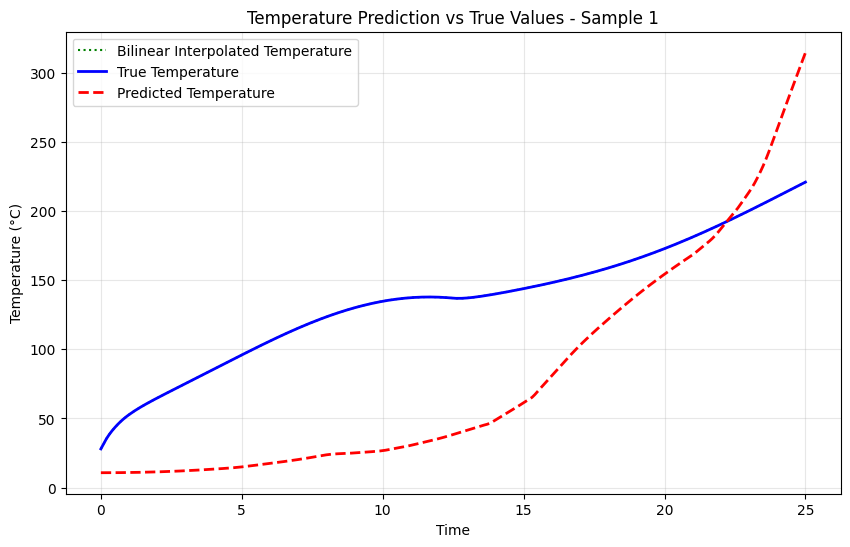

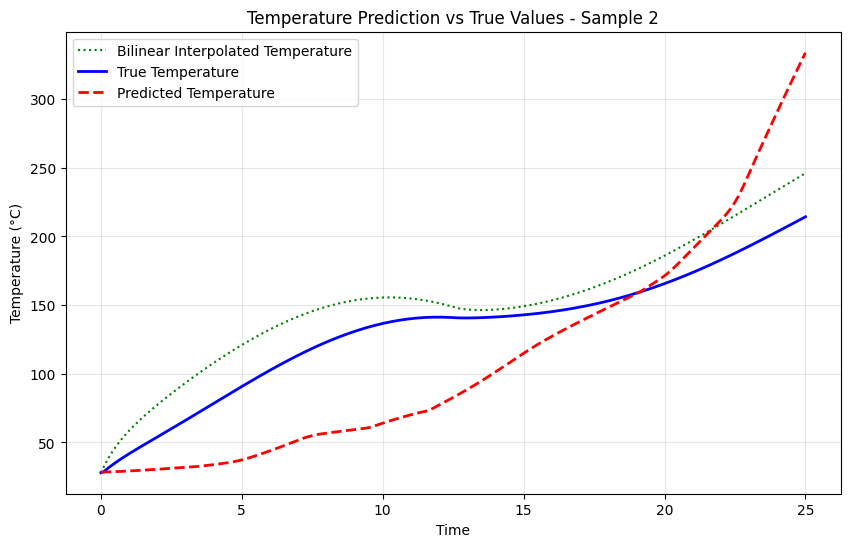

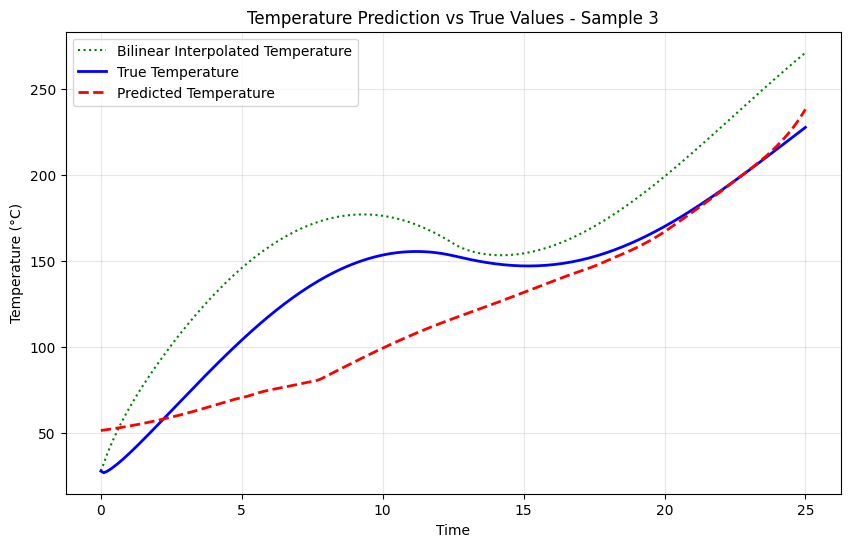

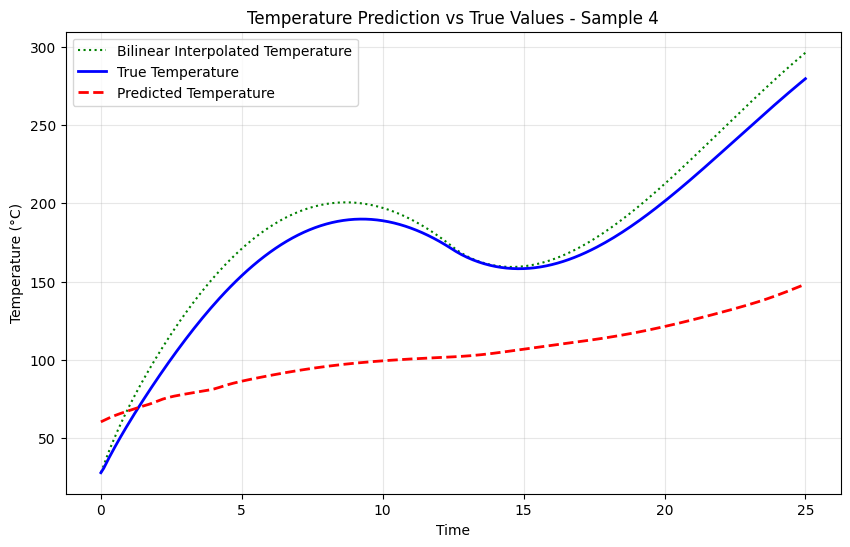

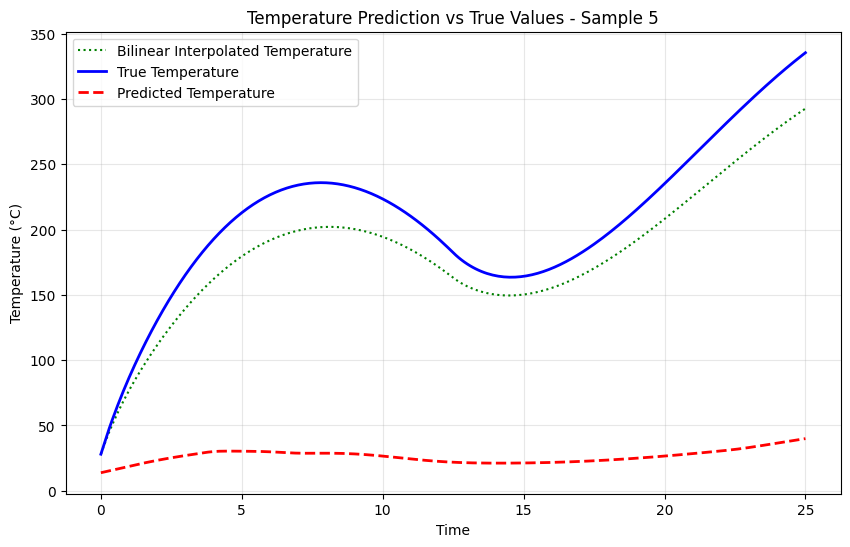

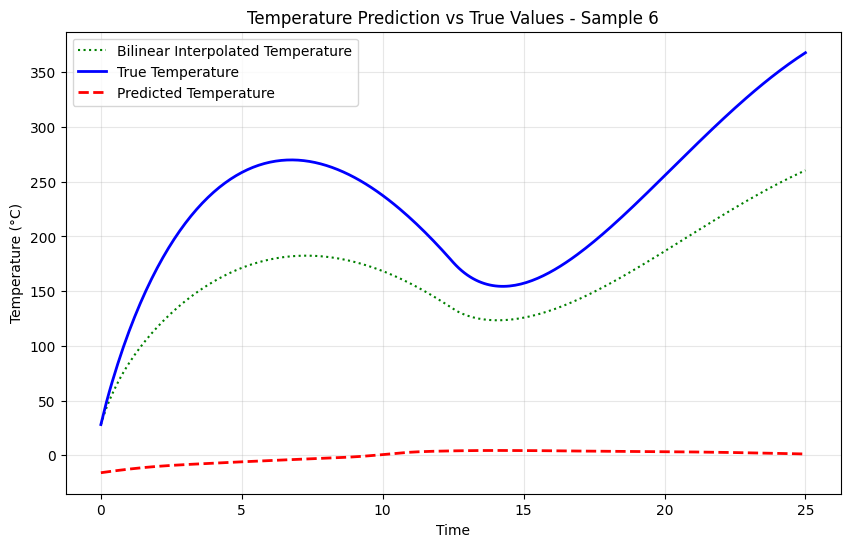

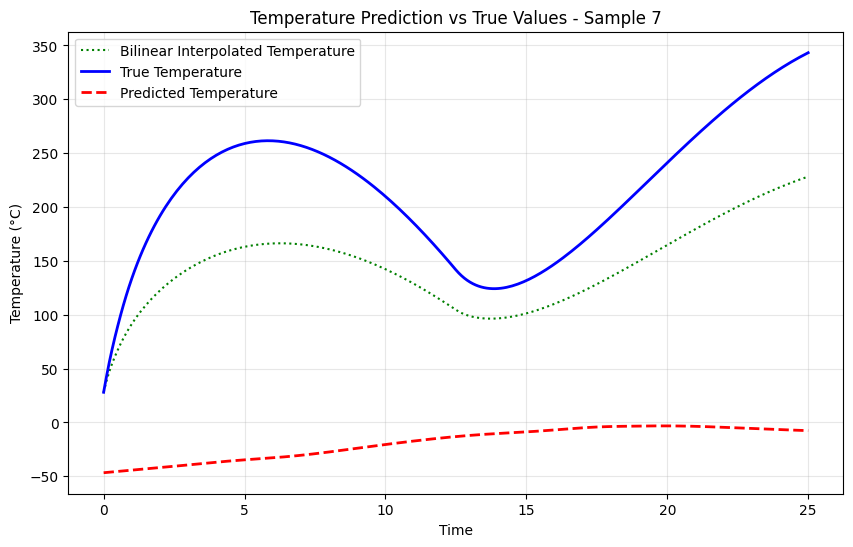

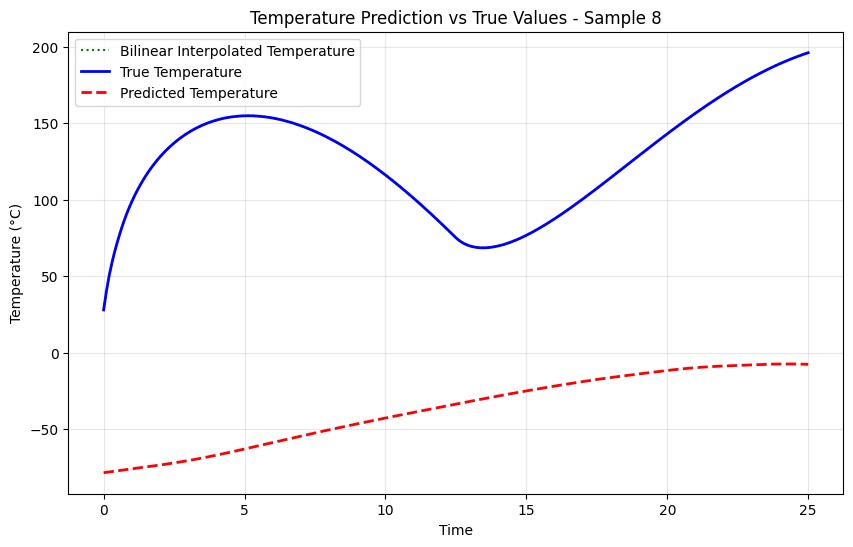

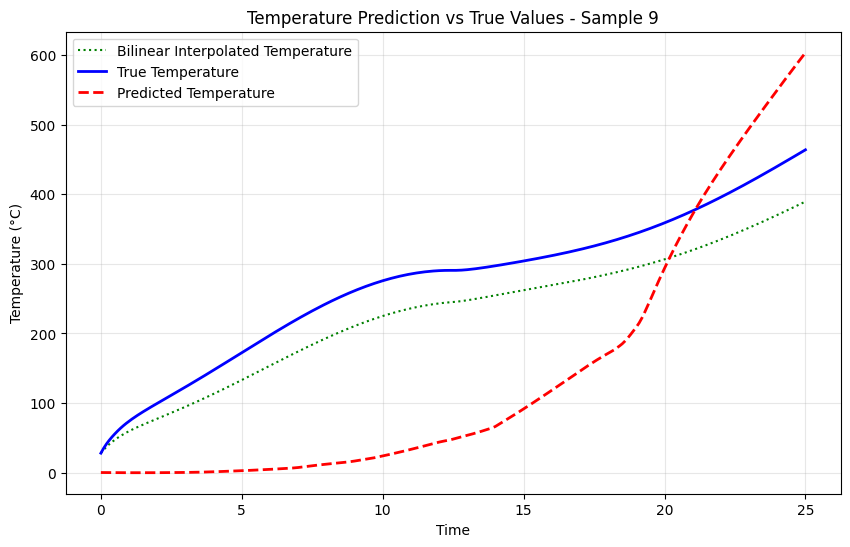

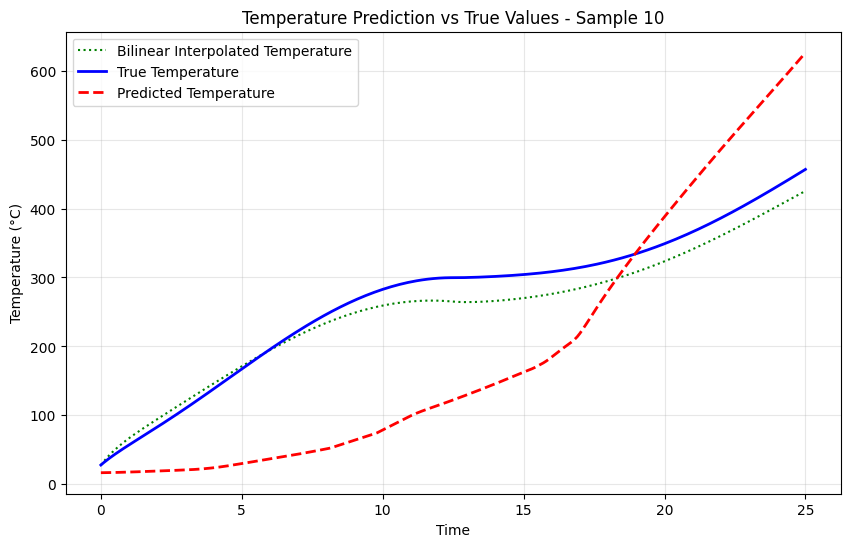

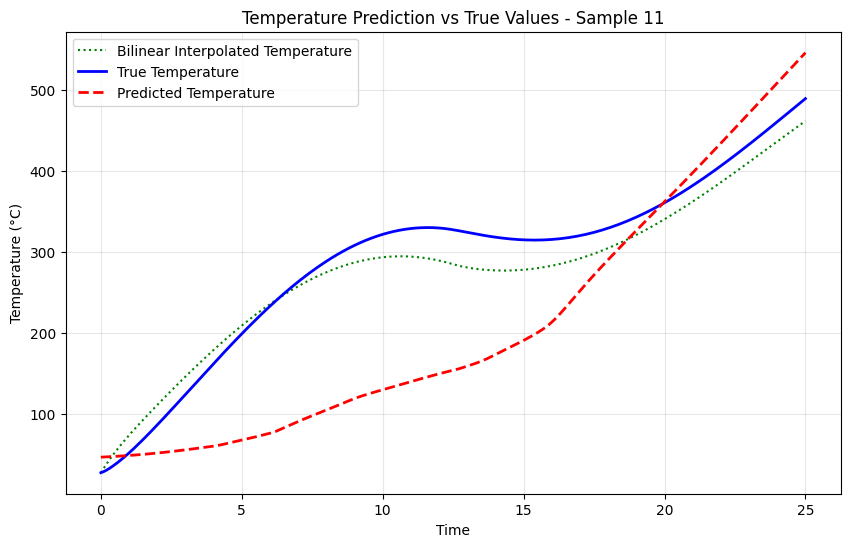

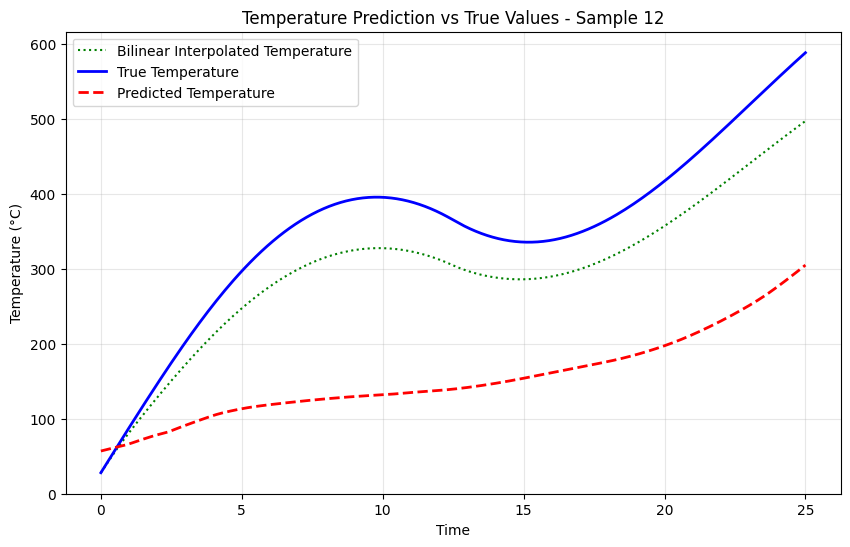

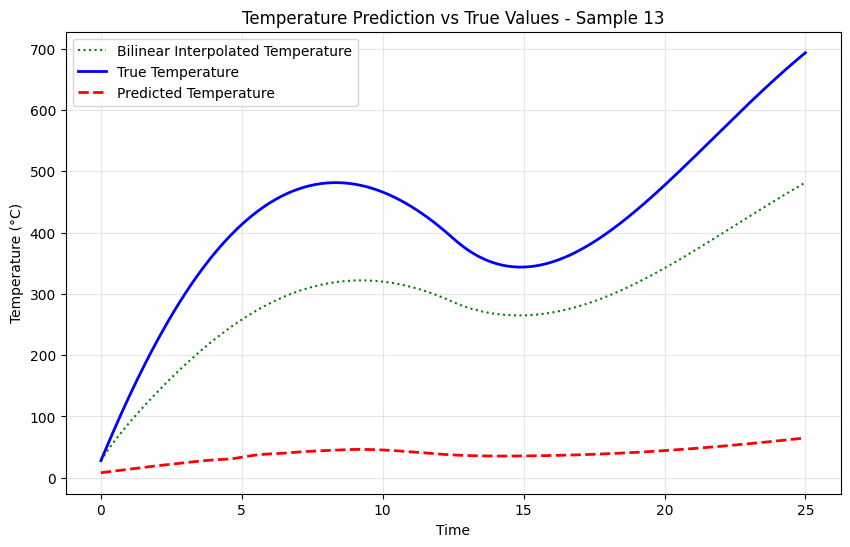

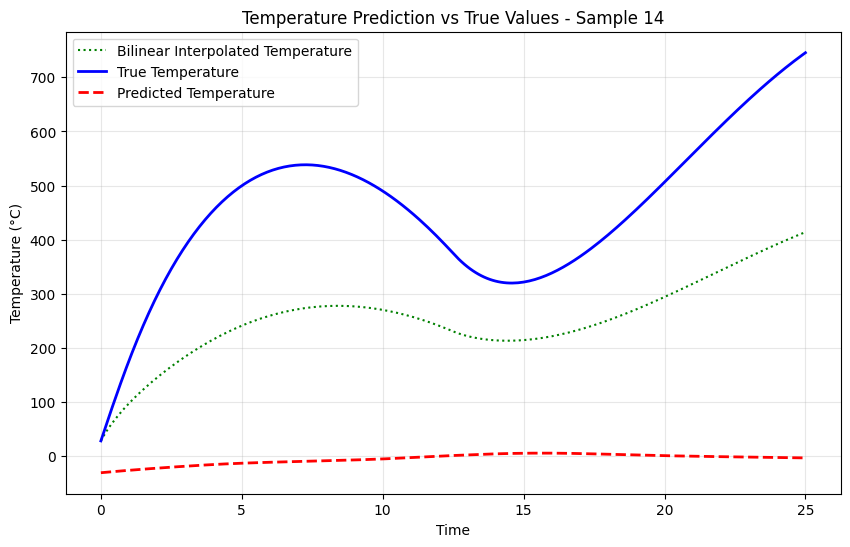

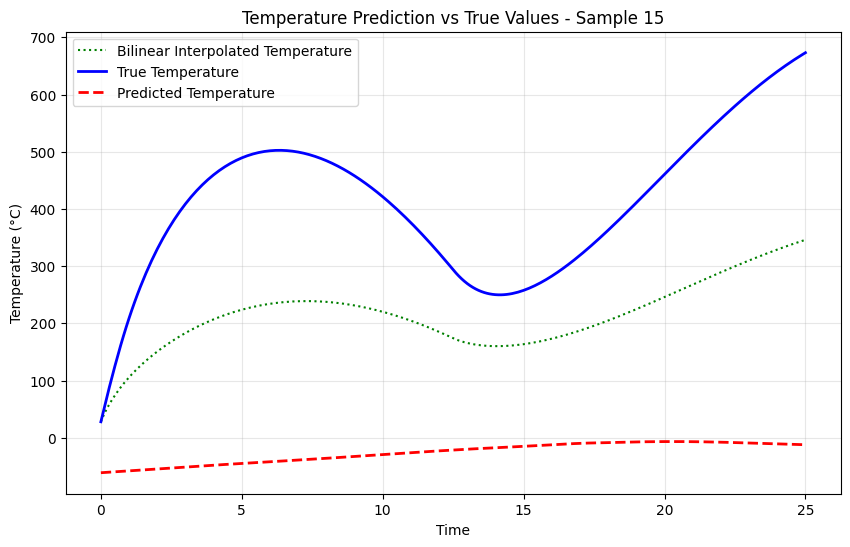

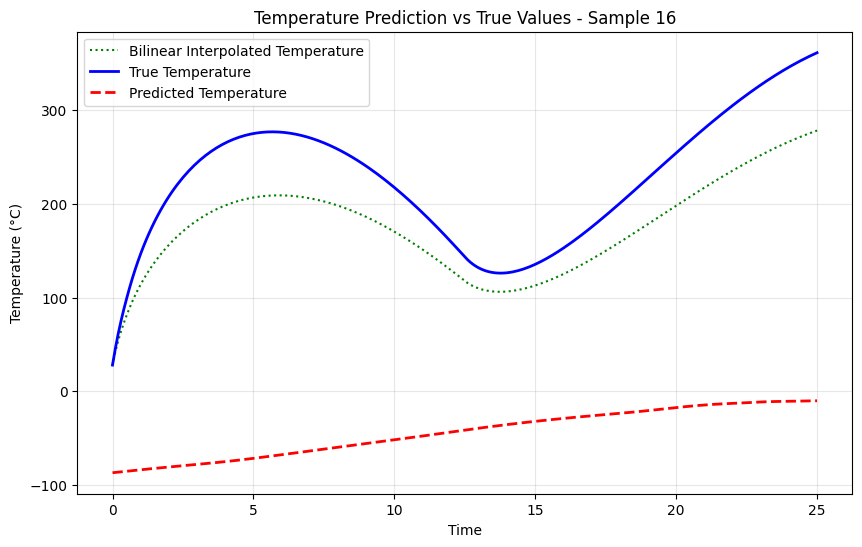

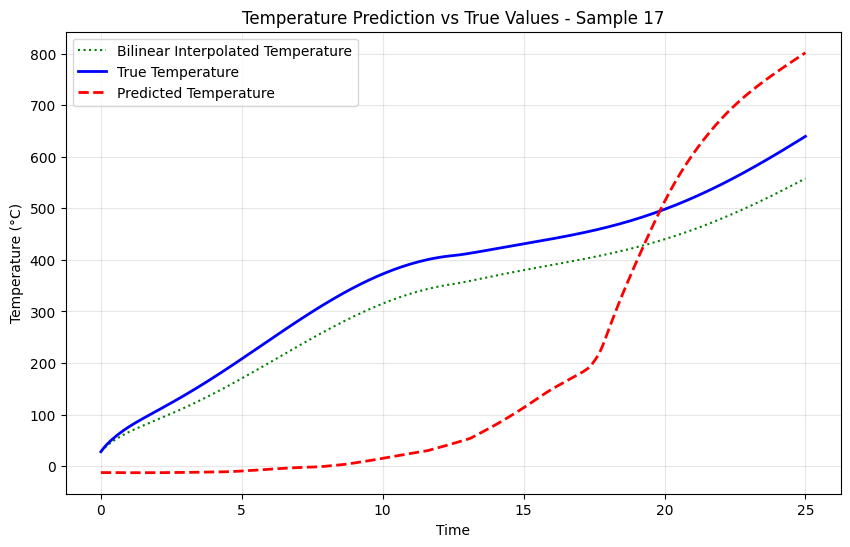

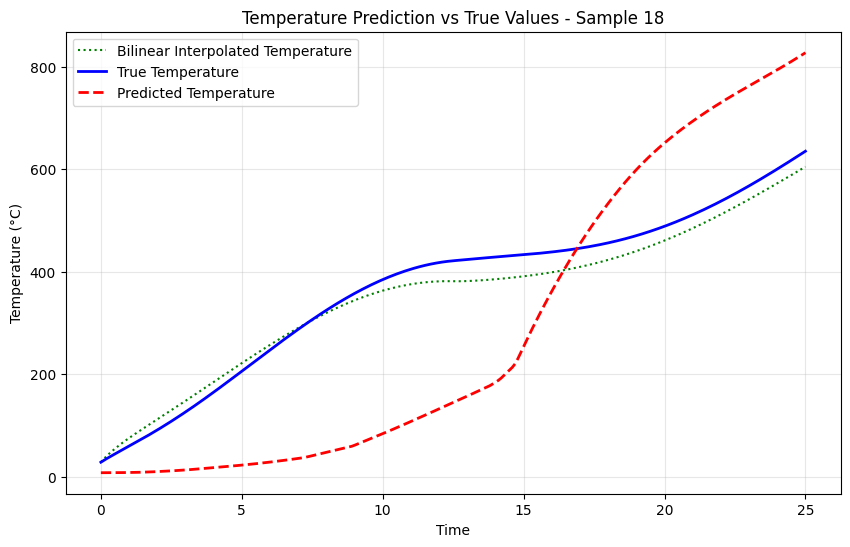

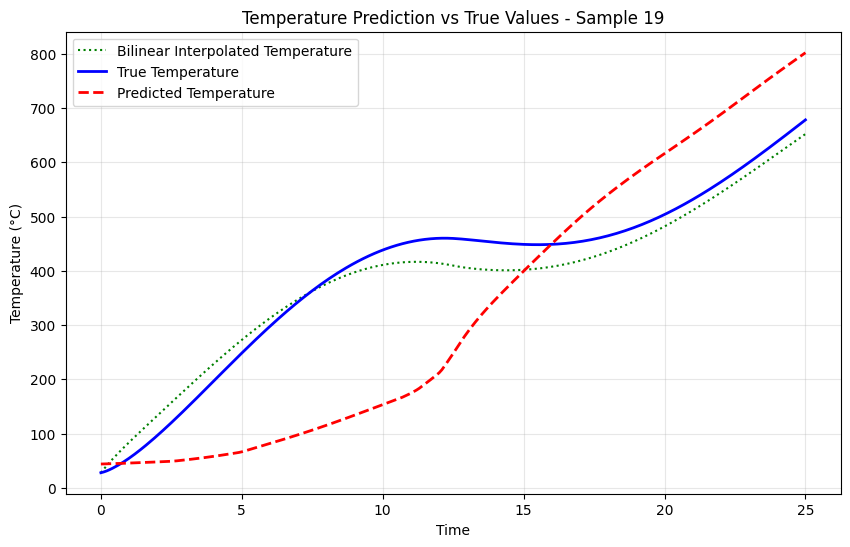

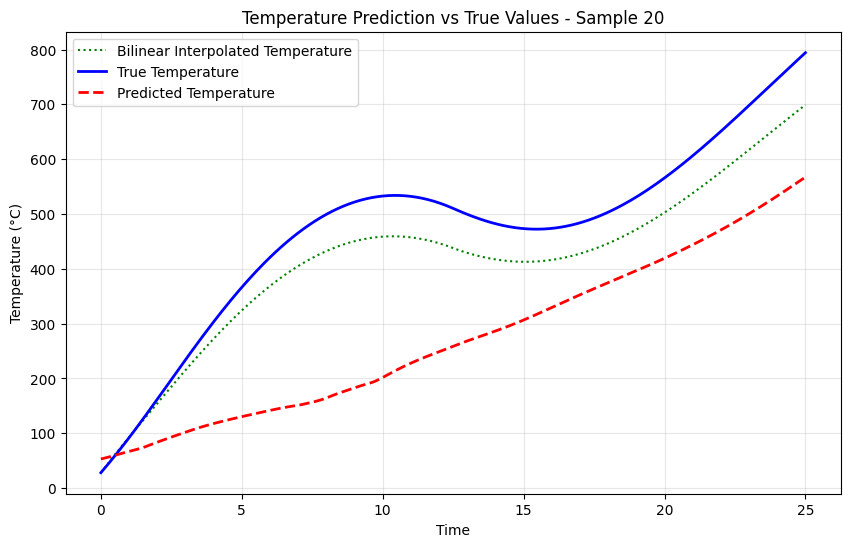

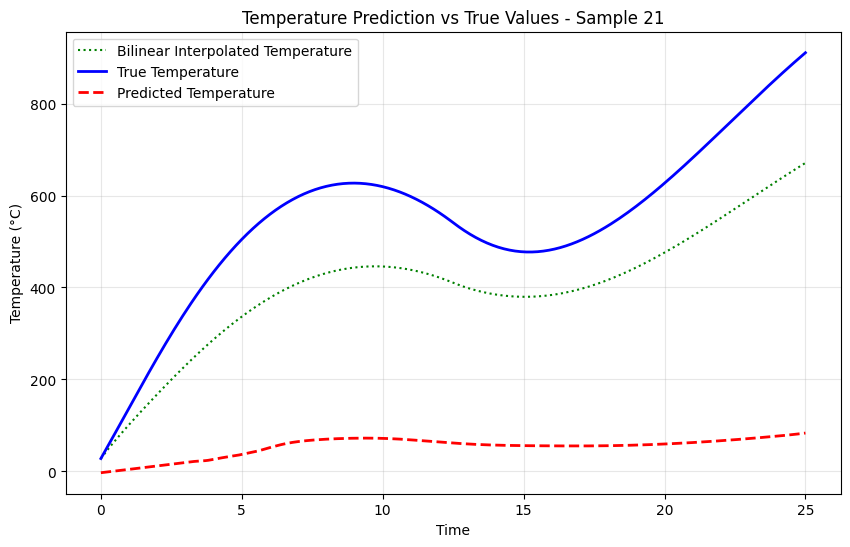

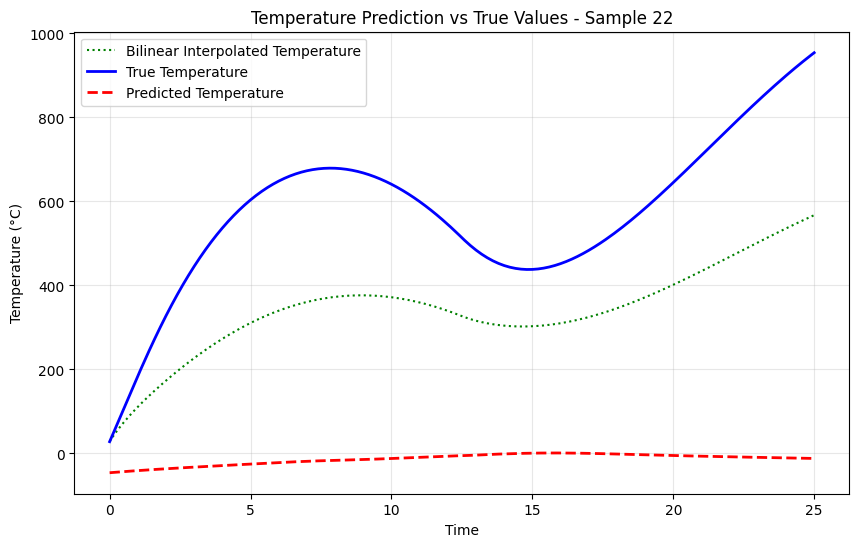

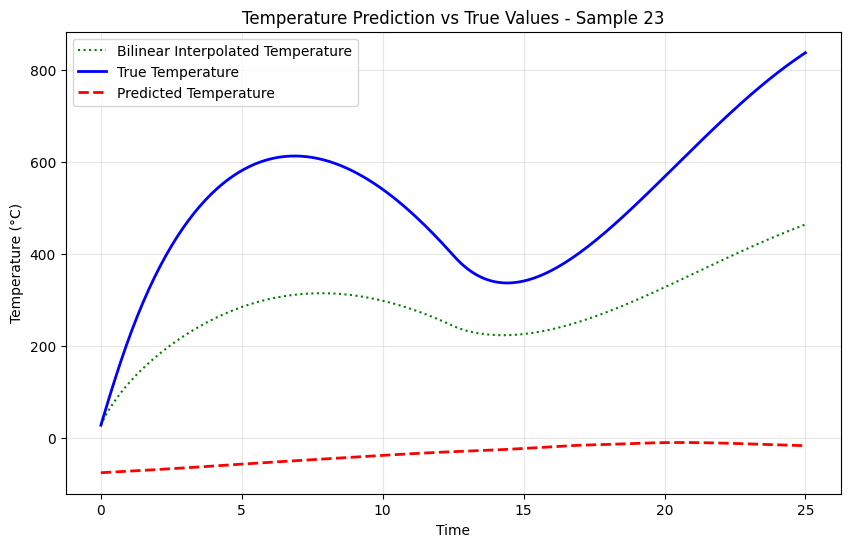

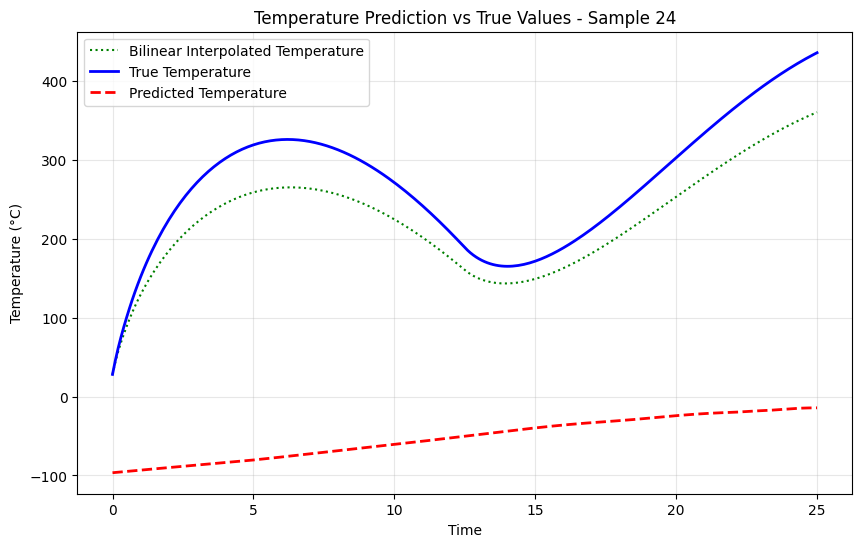

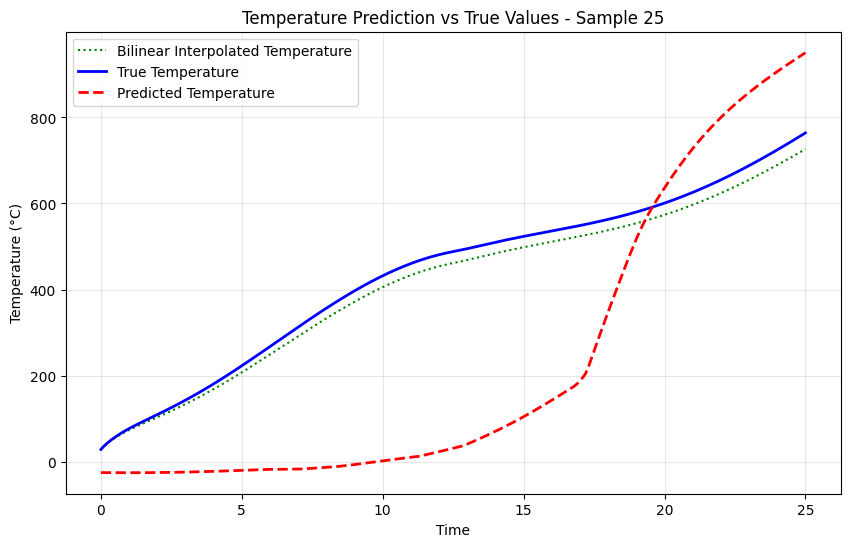

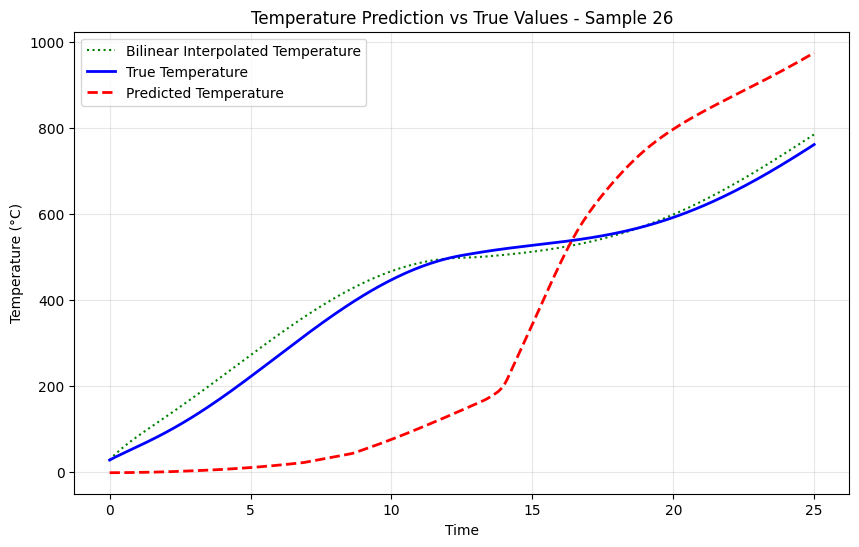

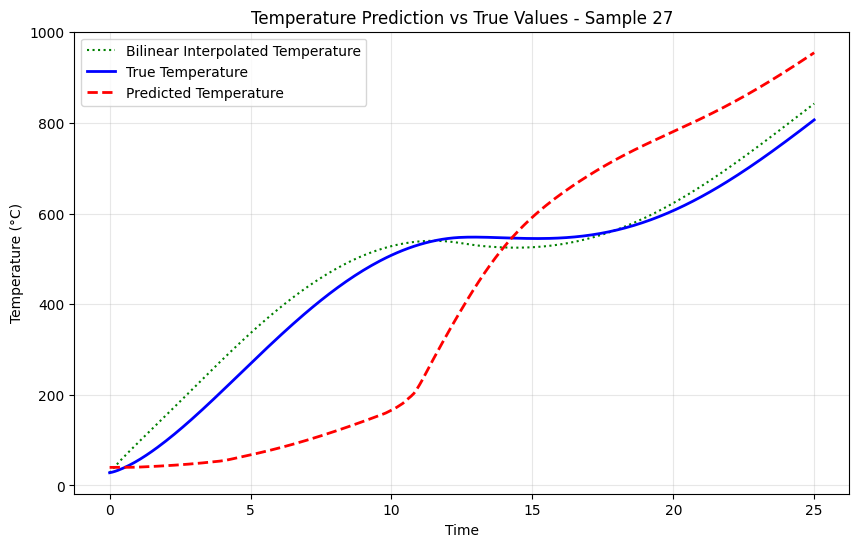

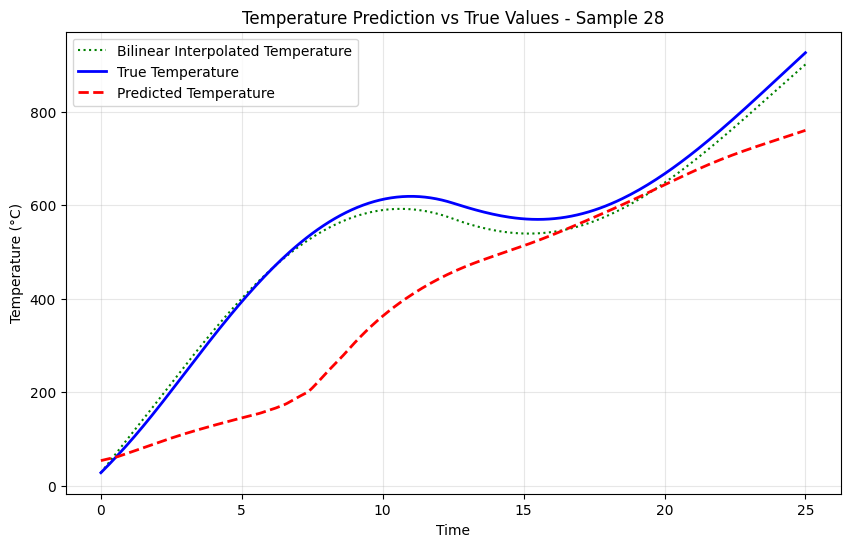

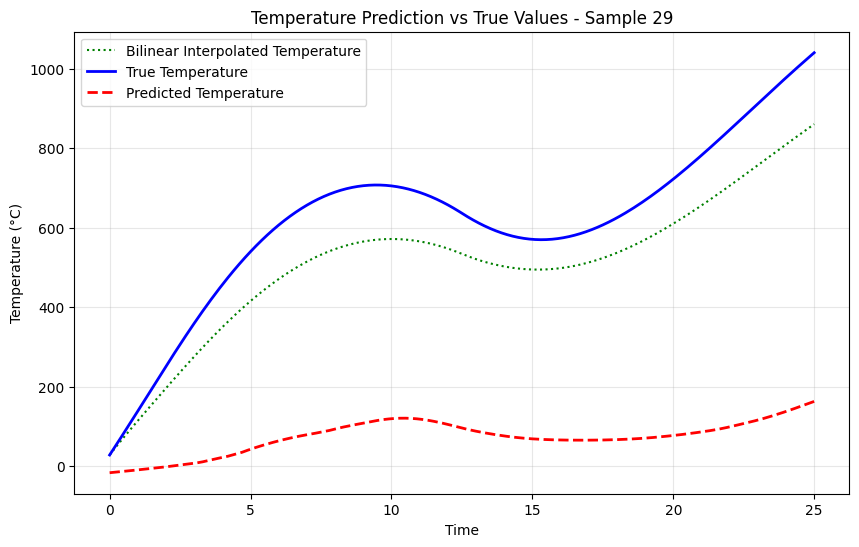

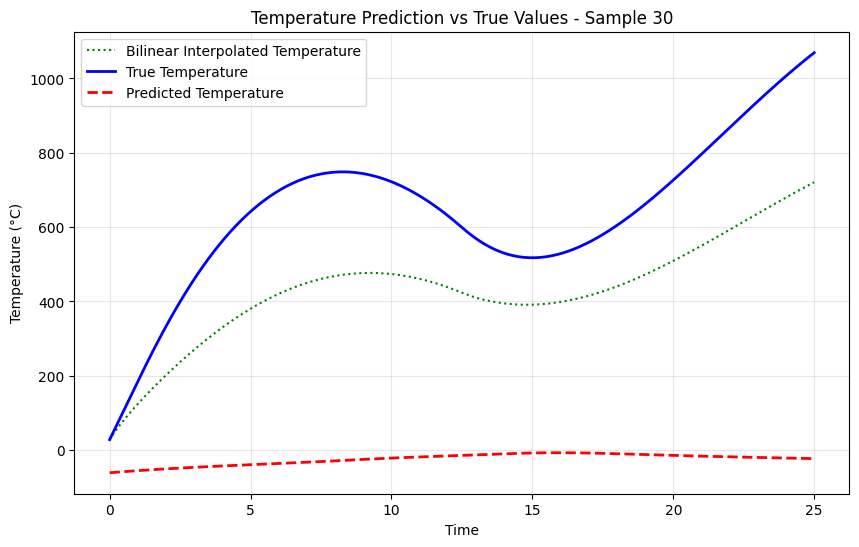

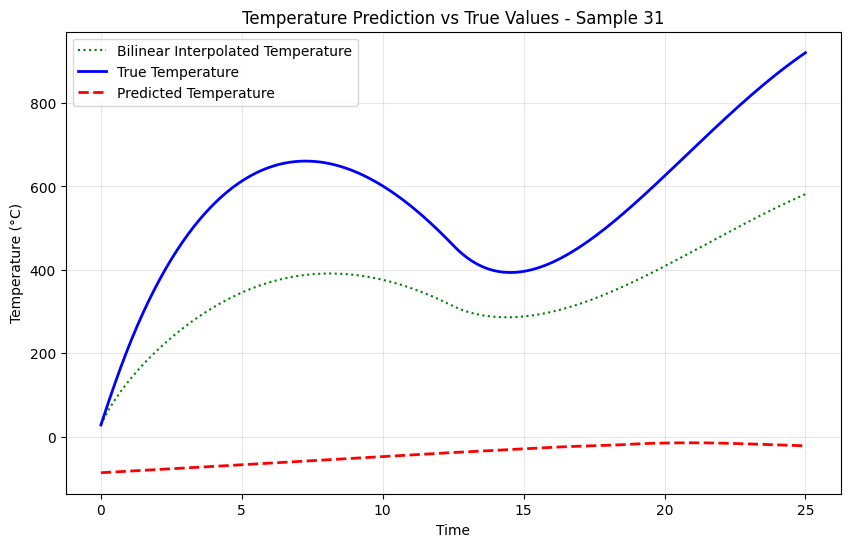

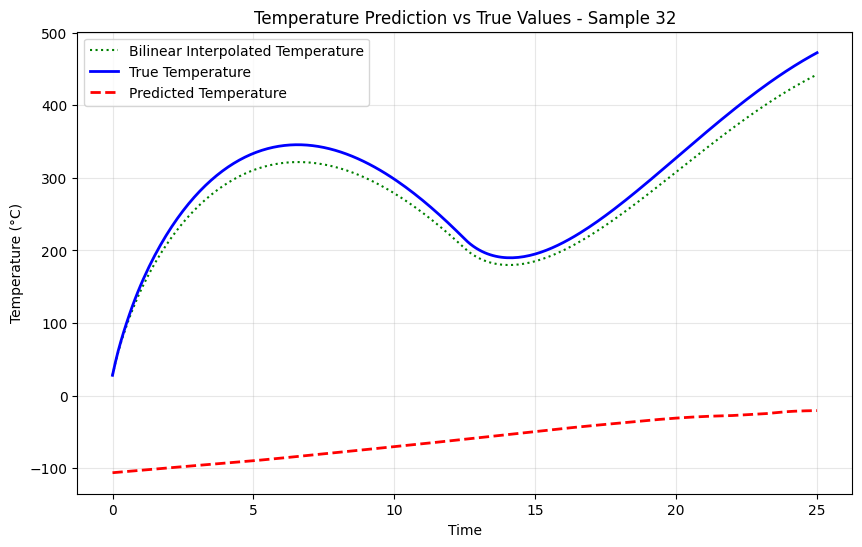

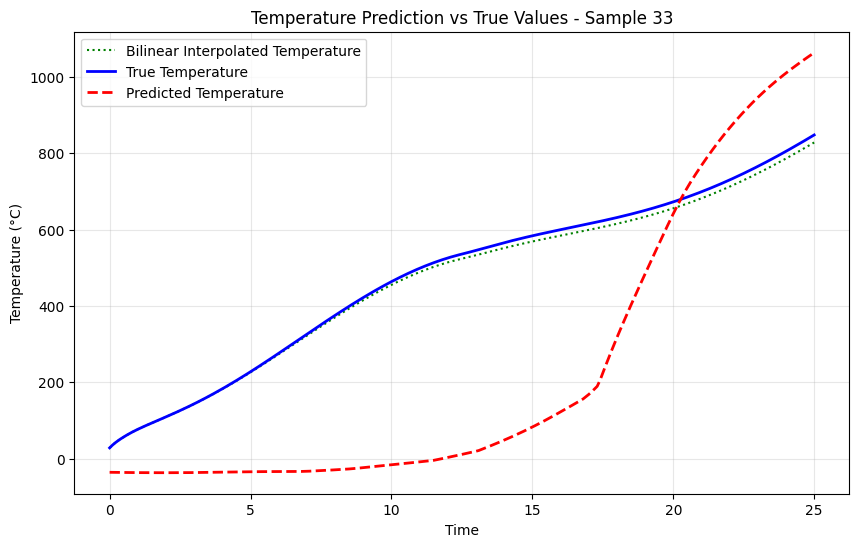

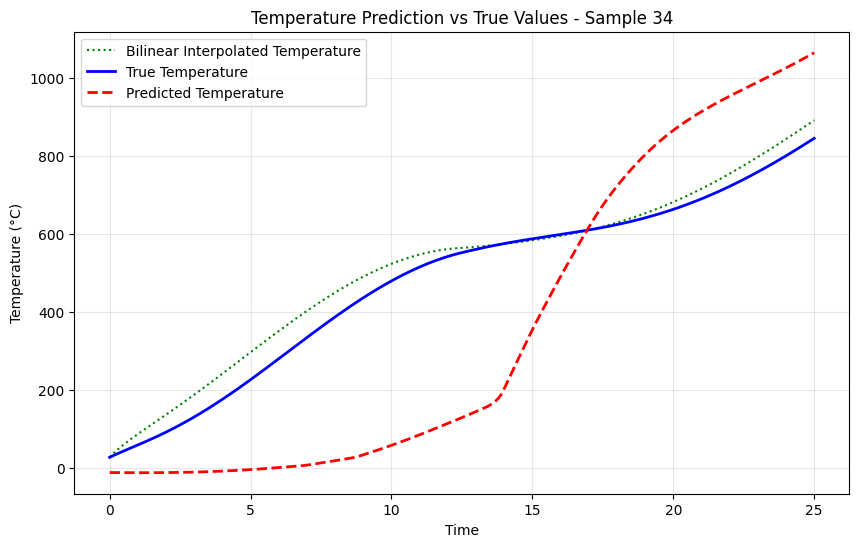

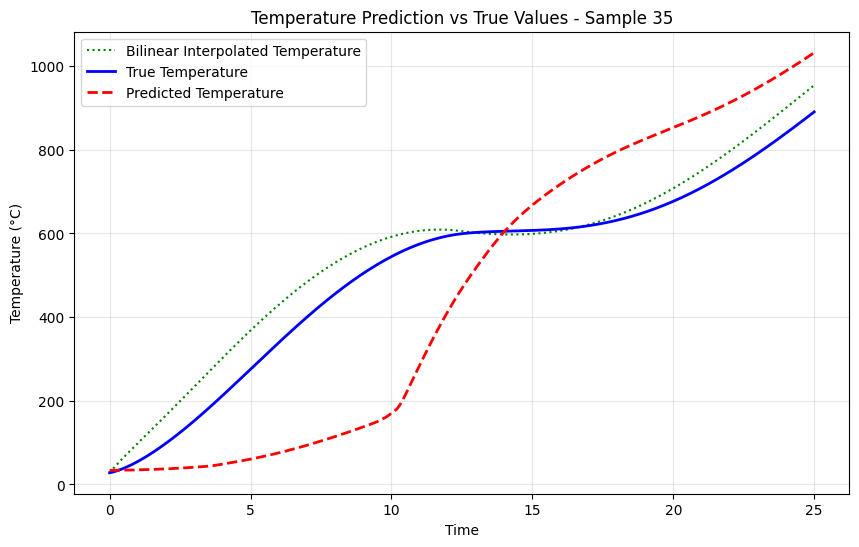

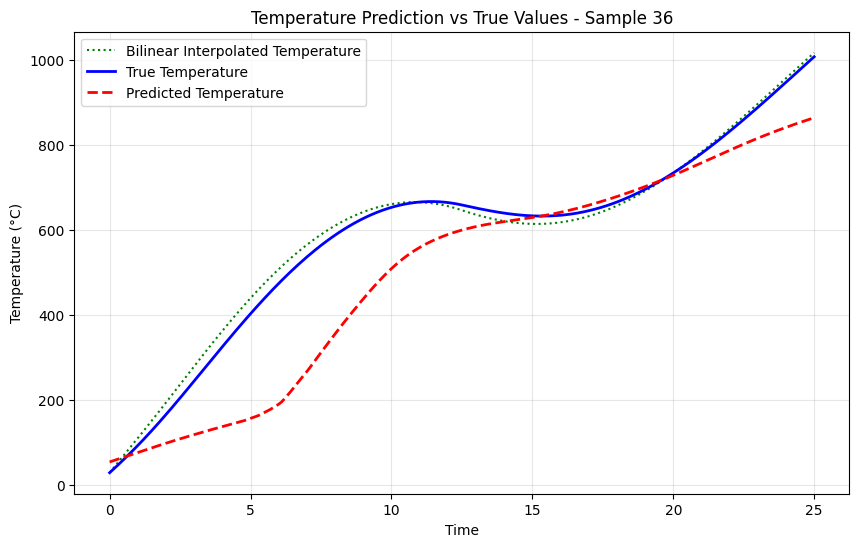

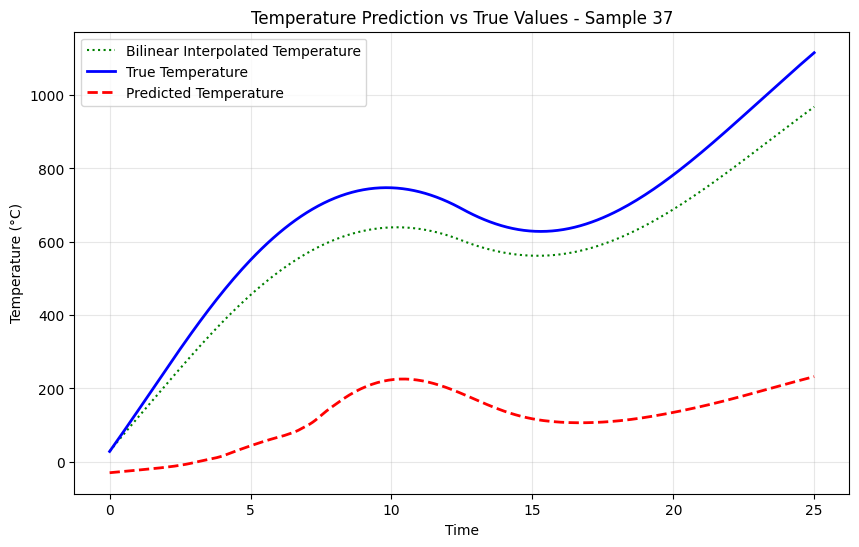

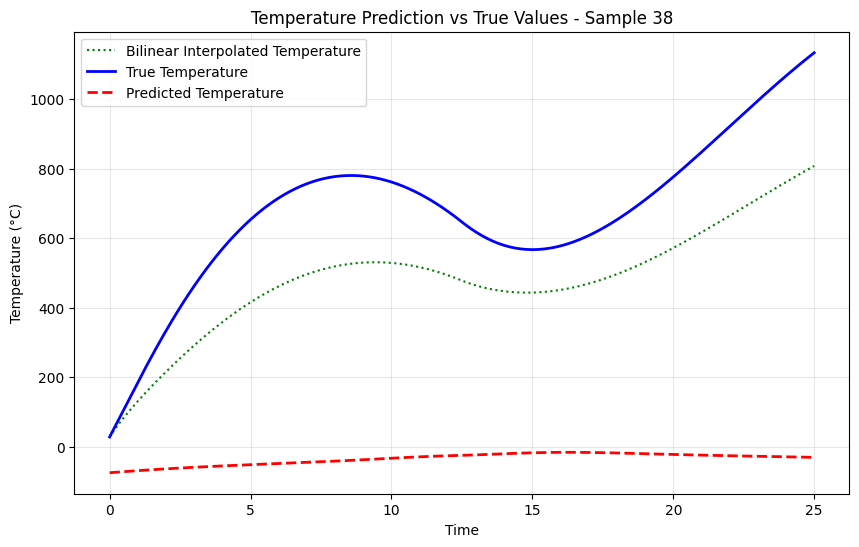

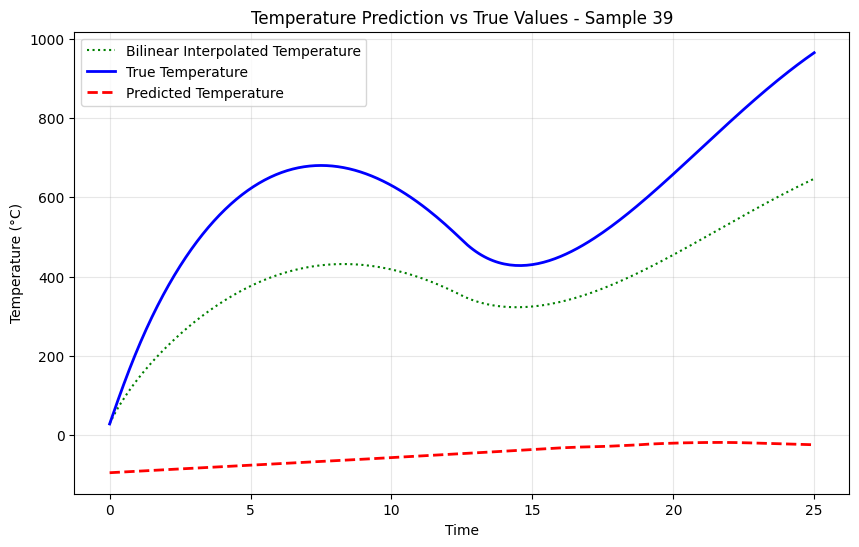

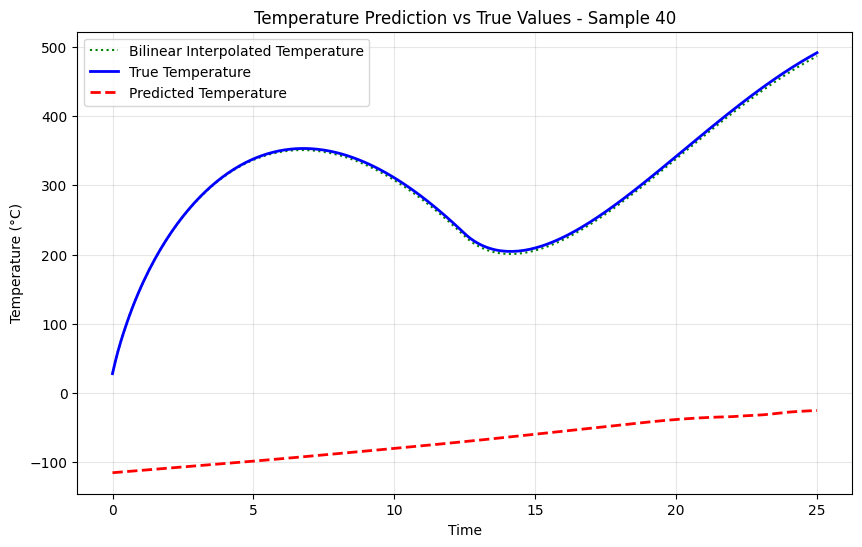

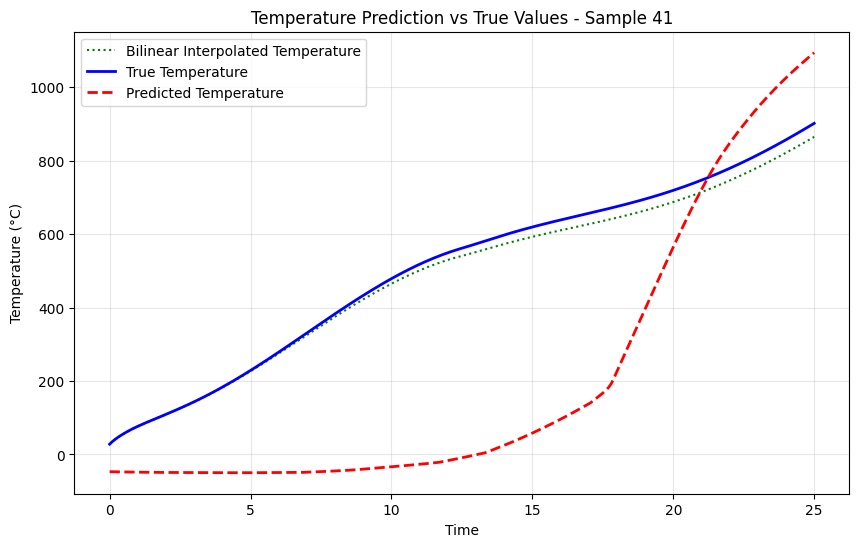

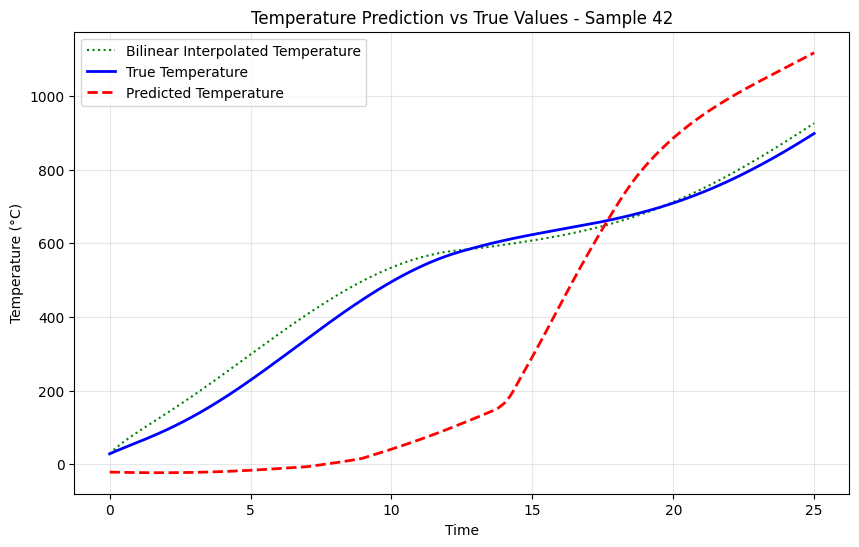

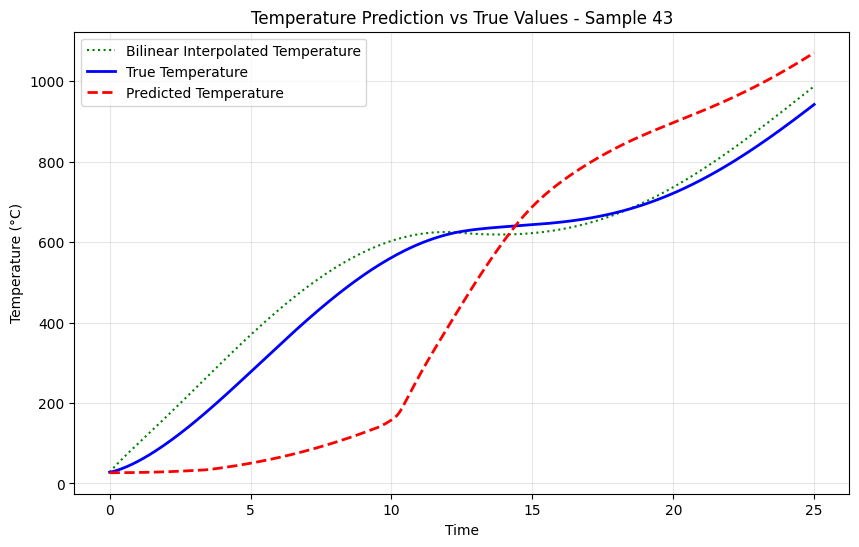

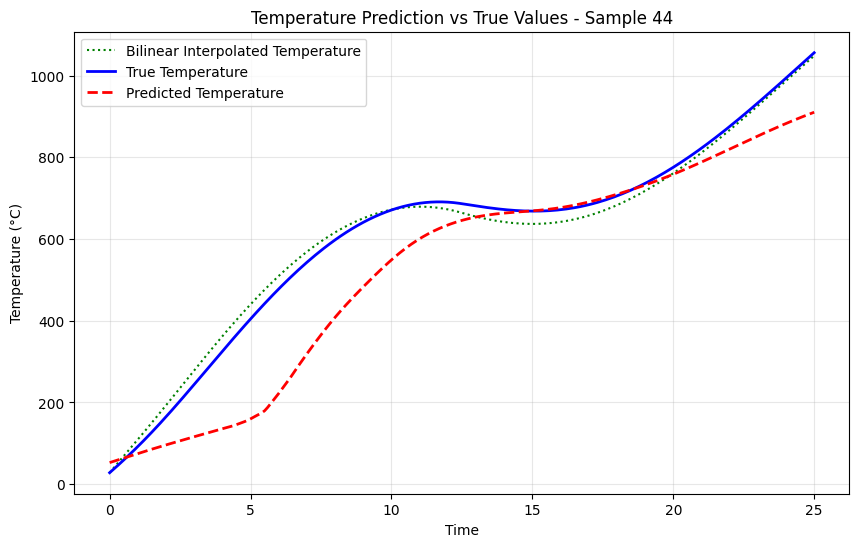

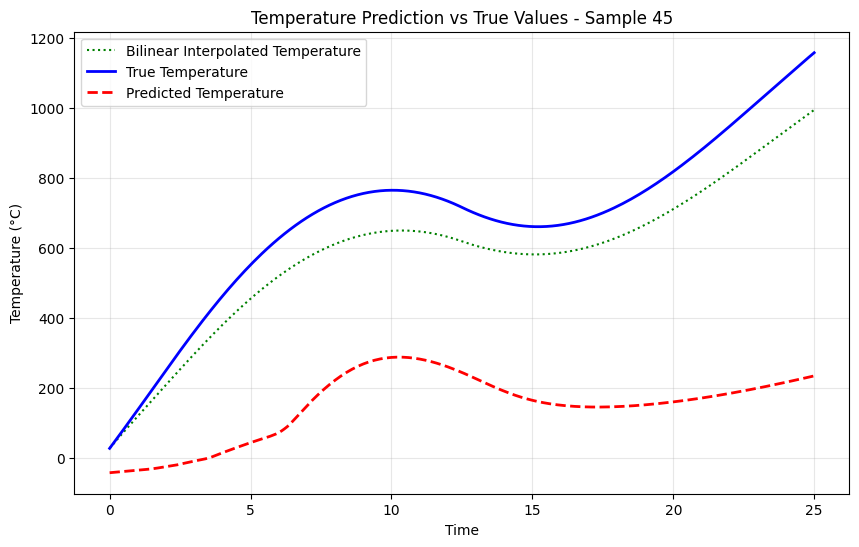

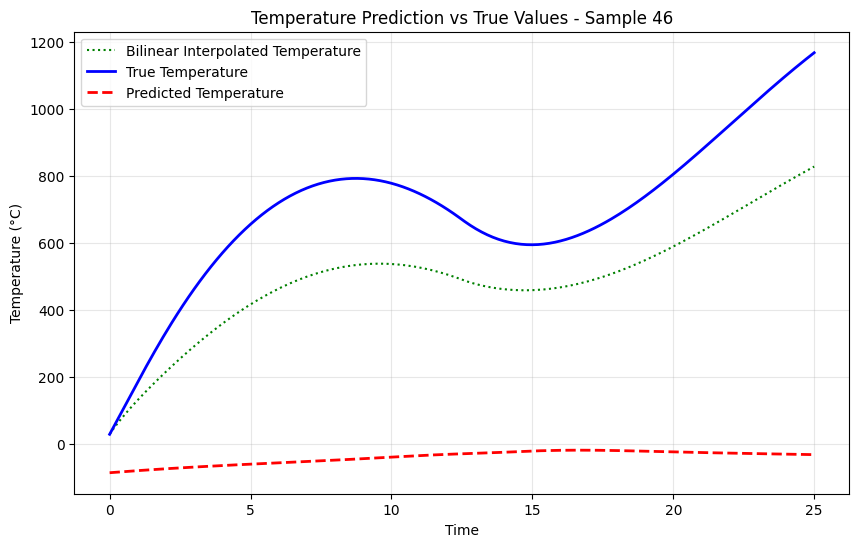

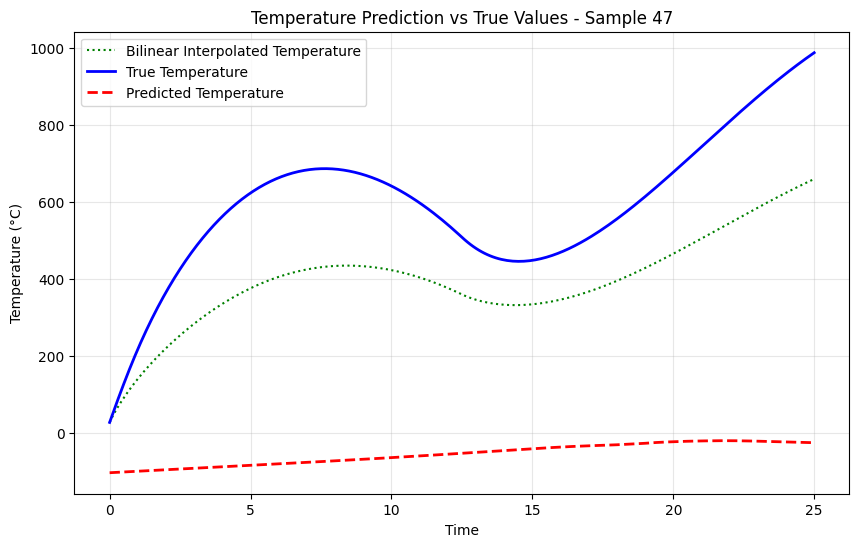

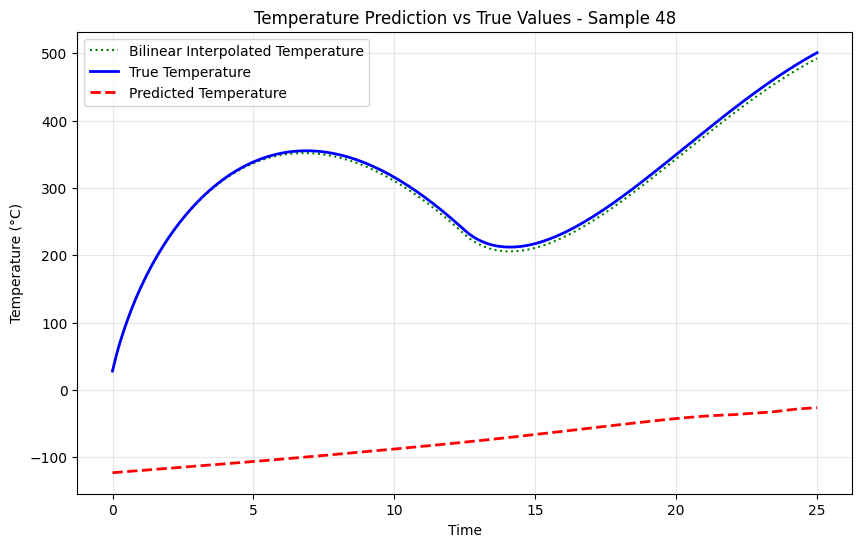

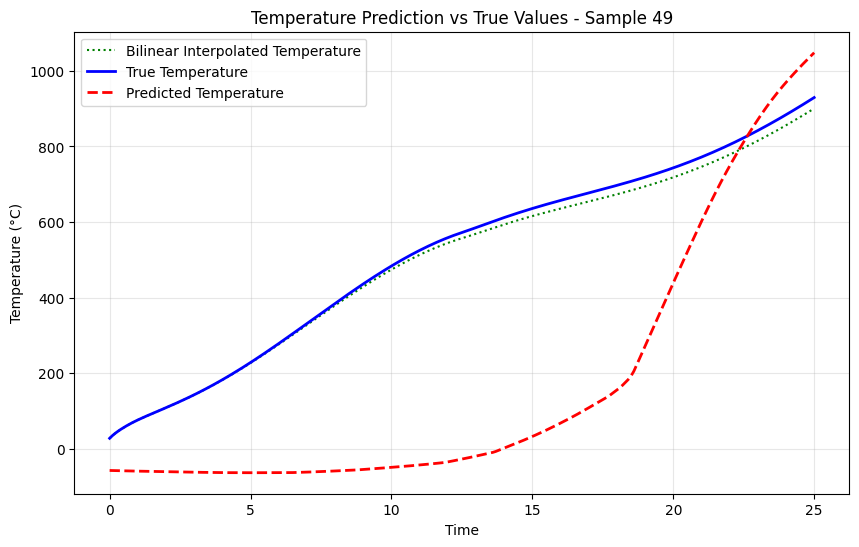

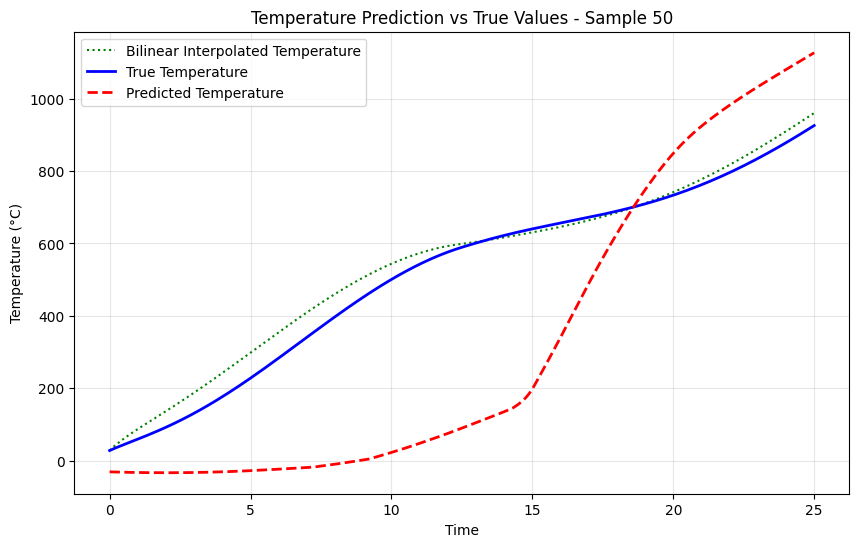

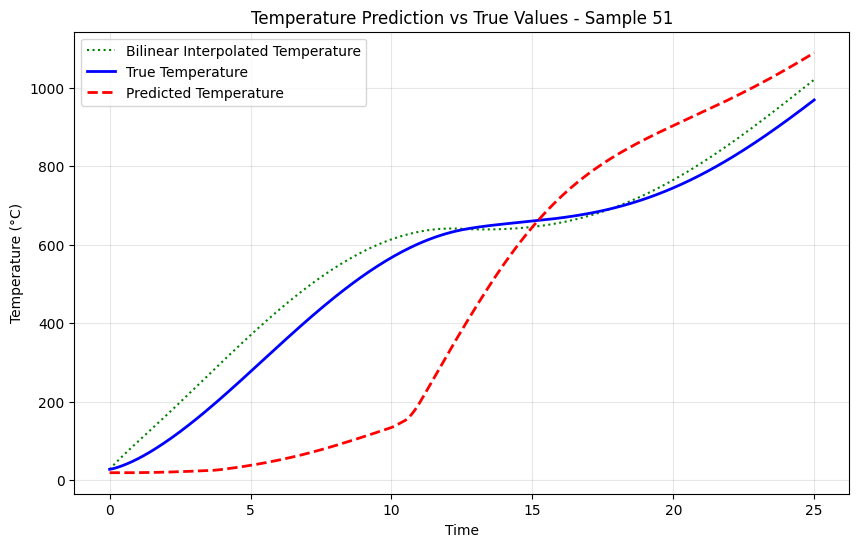

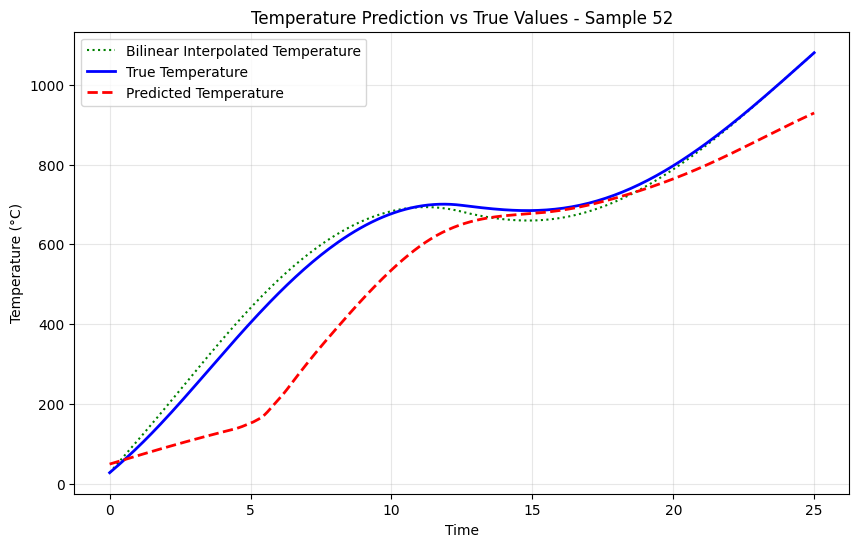

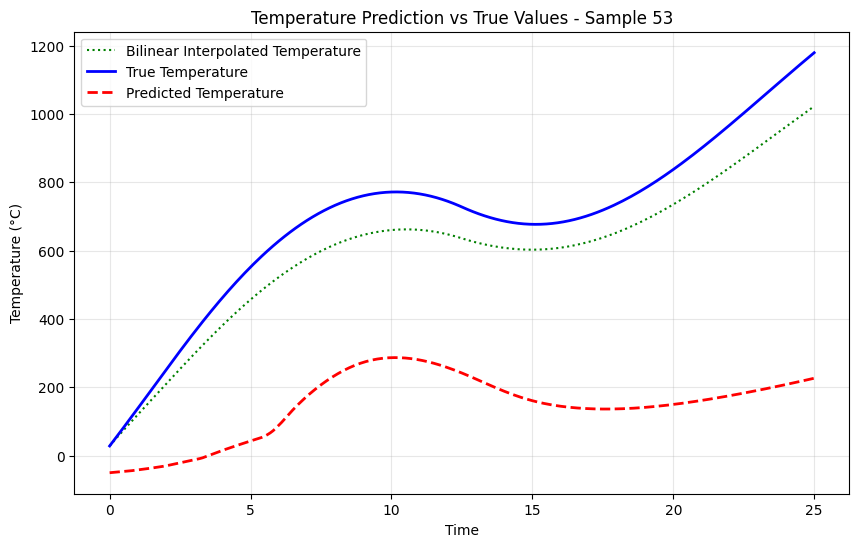

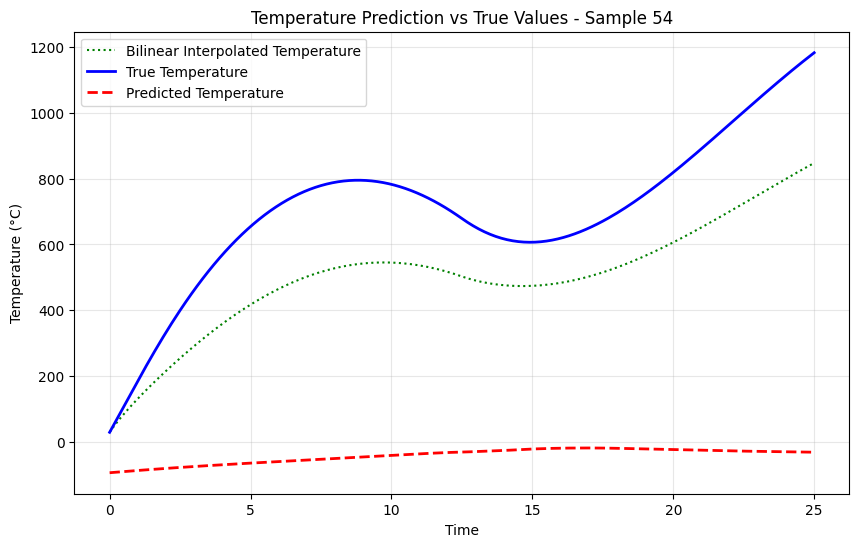

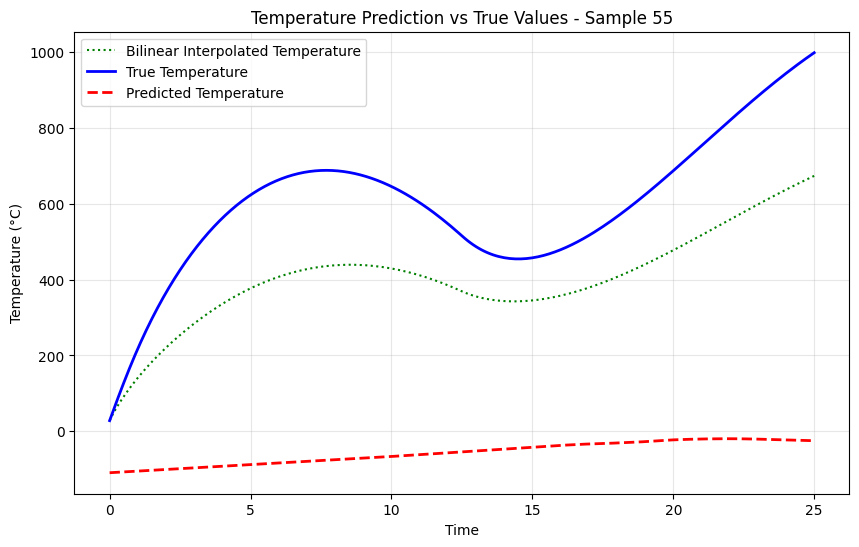

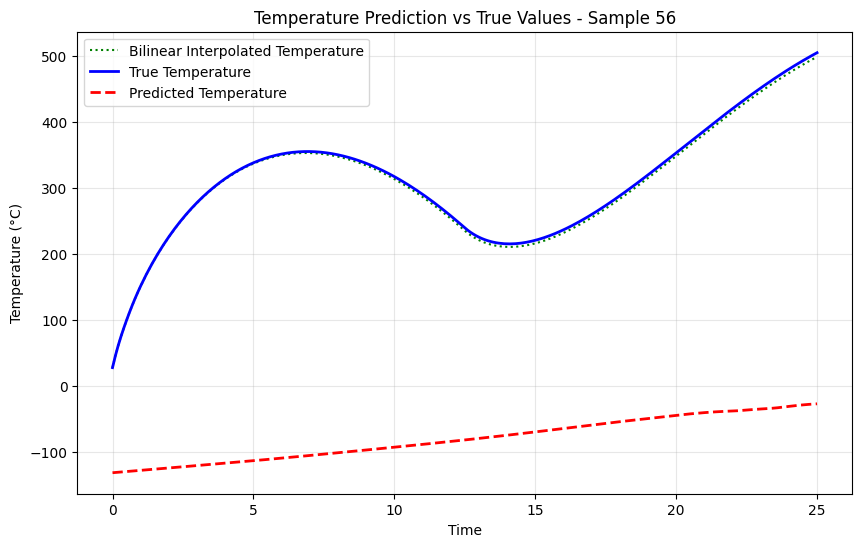

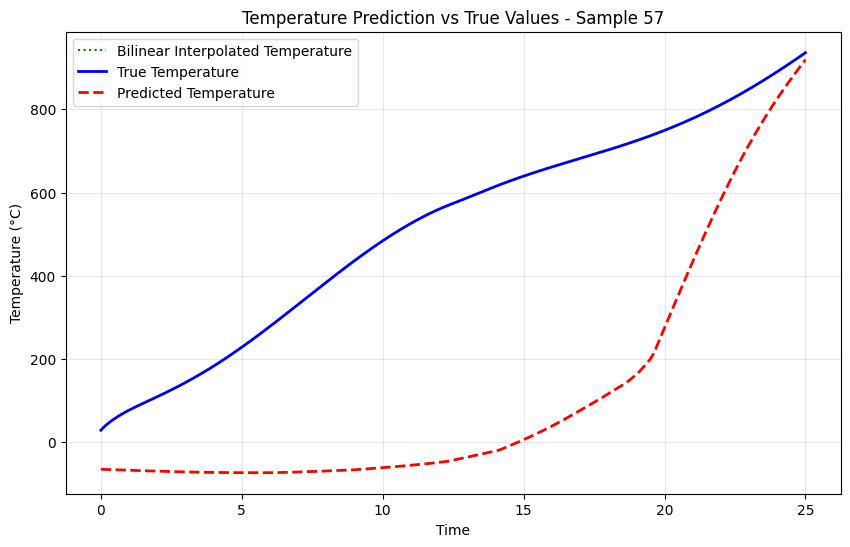

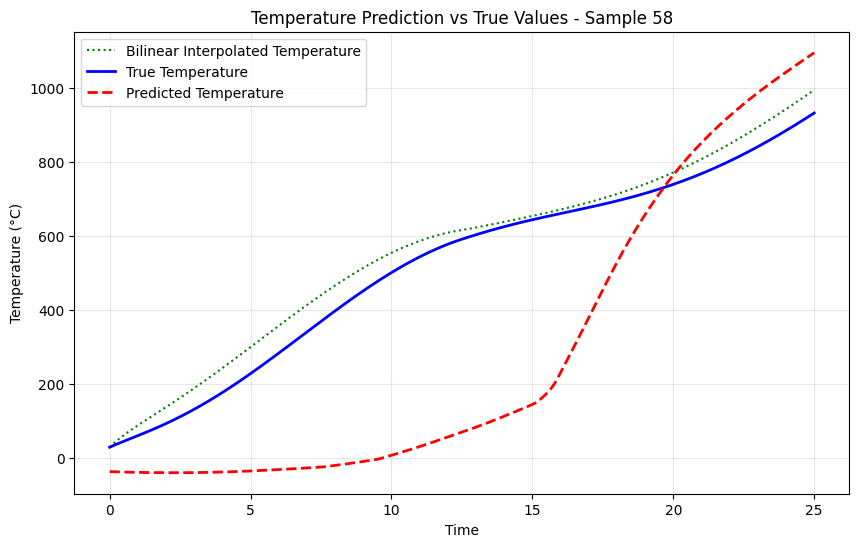

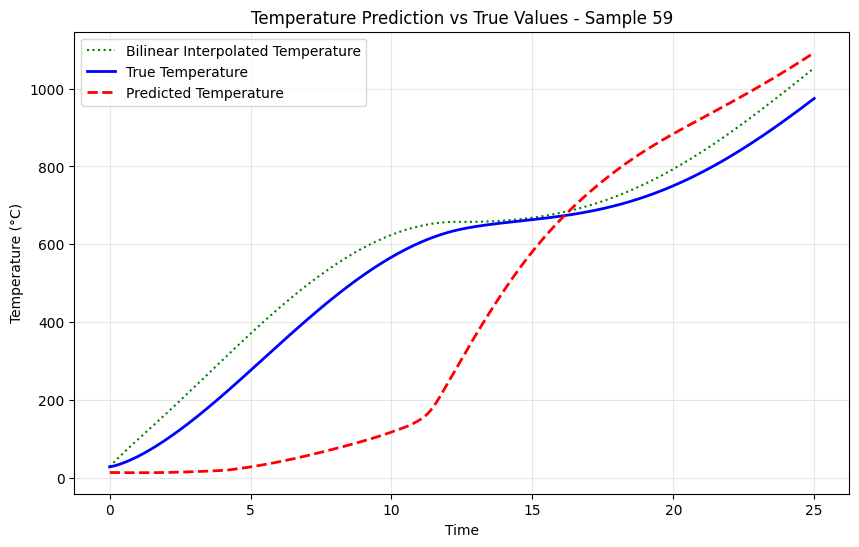

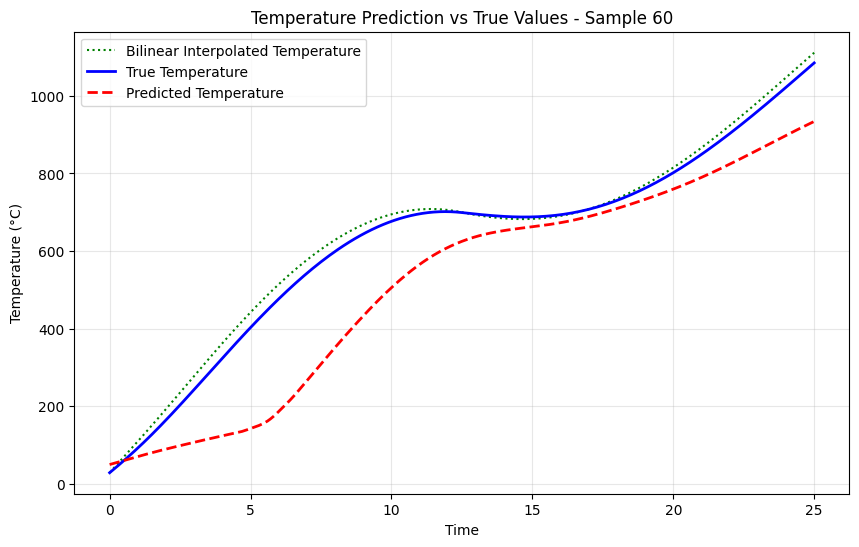

In [536]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

device = next(model.parameters()).device
print(f"Model is on device: {device}")

X_test = df_test_new.loc[:, ['r', 'z', 'time']].values  # Shape: (50, 3)
y_test = df_test_new['temperature'].values  # Shape: (50,)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation for faster inference
    y_pred = model(X_test).squeeze()

# Move results back to CPU for sklearn and matplotlib
y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()

# Calculate metrics
mse = mean_squared_error(y_test_cpu, y_pred_cpu)
print(f"Root Mean Squared Error NN: {mse**0.5:.4f}")

mse1 = mean_squared_error(df_test_new['bilinear_interpolated_temperature'], df_test_new['temperature'])
print(f"Root Mean Squared Error BL: {mse1**0.5:.4f}")
# Plotting - Make sure time_indices is defined
try:
    time_indices = df_test_new['time'].unique()  # Or however you define time_indices
except:
    # If time_indices not defined, create a simple range
    time_indices = range(251)  # Adjust based on your data structure

# Plot comparisons
for i in range(60):
    plt.figure(figsize=(10, 6))
    start_idx = i * 251
    end_idx = (i + 1) * 251
    plt.plot(df_test_new["time"][251*i:251*(i+1)],df_test_new['bilinear_interpolated_temperature'][251*i:251*(i+1)], label='Bilinear Interpolated Temperature', color='green', linestyle=":")
    plt.plot(time_indices, y_test_cpu[start_idx:end_idx],
             label='True Temperature', color='blue', linewidth=2)
    plt.plot(time_indices, y_pred_cpu[start_idx:end_idx],
             label='Predicted Temperature', color='red', linewidth=2, linestyle='--')

    plt.title(f'Temperature Prediction vs True Values - Sample {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [537]:
a = torch.tensor([[0,2,1],[1,1,0],[1,1,1]])
b = a[a[:, 0] == 0]
b

tensor([[0, 2, 1]])

In [538]:
a[0][1] == 2

tensor(True)